In [22]:
import warnings
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
from pprint import pprint
from rdkit import Chem, Geometry
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from core.utils import set_random_seed, Peptide
from core.visualization import (
    return_bond_sub_index,
    return_smask_index_i,
    get_summary,
)

## Evaluation on the whole datasets

In [23]:
warnings.filterwarnings('ignore')
set_random_seed()

In [24]:
prediction_dir = Path("../prediction")
summary_dir = prediction_dir / "summary"
attribution_dir = prediction_dir / "attribution"

prediction_dir.mkdir(exist_ok=True)
summary_dir.mkdir(exist_ok=True)
attribution_dir.mkdir(exist_ok=True)

In [25]:
task_name = "hla"

get_summary(task_name=task_name, sub_type="aa", summary_dir=summary_dir, prediction_dir=prediction_dir)
get_summary(task_name=task_name, sub_type="mol", summary_dir=summary_dir, prediction_dir=prediction_dir)

In [26]:
attribution_result = pd.DataFrame()

# 掩码和不带掩码的结果
result_sub = pd.read_csv(summary_dir / f"{task_name}_aa_prediction_summary.csv")
result_mol = pd.read_csv(summary_dir / f"{task_name}_mol_prediction_summary.csv")

print(len(result_sub), len(result_mol))

158841 17079


In [27]:
def get_preds(result_mol, result_sub, preds_str, task_name):
    """
    Get predictions for the given task and save them to a numpy file if not already saved.
    
    Parameters:
        result_mol (pd.DataFrame): DataFrame containing molecular results.
        result_sub (pd.DataFrame): DataFrame containing subset of results.
        preds_str (str): Prediction type string, e.g., 'pred_mean' or 'pred_std'.
        task_name (str): Name of the task for naming the numpy file.
    
    Returns:
        list: List of predictions.
    """
    npy_path = Path(f"../tmp/mol_{task_name}_{preds_str}_list_for_sub.npy")
    if npy_path.exists():
        print(f"Loading data from {npy_path}")
        return np.load(npy_path, allow_pickle=True).tolist()
    
    rtn_list = []
    for seq in tqdm(result_sub["sequence"], desc=f"Processing for getting {preds_str}"):
        pred_value = result_mol.loc[result_mol["sequence"] == seq, preds_str].values[0]
        rtn_list.append(pred_value)
    
    np.save(npy_path, np.array(rtn_list, dtype=object), allow_pickle=True)
    print(f"Saved data to {npy_path}")
    return rtn_list

mol_pred_mean_list_for_sub = get_preds(result_mol, result_sub, "pred_mean", task_name="hla")
mol_pred_std_list_for_sub = get_preds(result_mol, result_sub, "pred_std", task_name="hla")

Loading data from ../tmp/mol_hla_pred_mean_list_for_sub.npy
Loading data from ../tmp/mol_hla_pred_std_list_for_sub.npy


In [28]:
attribution_result["sequence"] = result_sub["sequence"]
attribution_result["smiles"] = result_sub["smiles"]
attribution_result["label"] = result_sub["label"]
attribution_result["sub_name"] = result_sub["sub_name"]
attribution_result["group"] = result_sub["group"]
attribution_result["sub_pred_mean"] = result_sub["pred_mean"]
attribution_result["sub_pred_std"] = result_sub["pred_std"]

attribution_result["mol_pred_mean"] = mol_pred_mean_list_for_sub
attribution_result["mol_pred_std"] = mol_pred_std_list_for_sub

attribution_result["attribution"] = (
    attribution_result["mol_pred_mean"] - attribution_result["sub_pred_mean"]
)
attribution_result["attribution_normalized"] = (
    np.exp(attribution_result["attribution"].values)
    - np.exp(-attribution_result["attribution"].values)
) / (
    np.exp(attribution_result["attribution"].values)
    + np.exp(-attribution_result["attribution"].values)
)

sub_pred_std_list = result_sub["pred_std"]

attribution_result.to_csv(
    attribution_dir / f"{task_name}_aa_attribution_summary.csv", index=False
)

## Visialization

In [29]:
def return_rings_attribution(mol, sub_index, sub_atom_attribution_list, fg=False):
    ring_index = [list(ring) for ring in Chem.GetSymmSSSR(mol)]
    print(sub_index, sub_atom_attribution_list)
    ring_attribution_index = []

    # 官能团时，没有返回所有原子的 attribution,因此需要重新对应
    if fg:
        ring_attribution = []
        sub_atom_count = 0
        for sub in sub_index:
            ring_attribution.append(sub_atom_attribution_list[sub_atom_count])
            sub_atom_count = sub_atom_count + len(sub)

    # 判断环在哪个子结构中，并返回对应的 attribution
    final_ring_index = []
    for ring in ring_index:
        for i, sub in enumerate(sub_index):
            if len(list(set(ring).intersection(set(sub)))) > 0:
                if fg:
                    ring_attribution_index.append(ring_attribution[i])
                    final_ring_index.append(ring)
                else:
                    ring_attribution_index.append(sub_atom_attribution_list[sub[0]])
                    final_ring_index.append(ring)
    return final_ring_index, ring_attribution_index


def return_atom_and_sub_attribution(
    peptide,
    smask_index,
    attribution,
):
    """返回多肽的原子和子结构贡献度

    Args:
        peptide (Peptide): 多肽
        smask_index (_type_): 掩码索引
        attribution (_type_): 贡献度

    Returns:
        返回每一个贡献度列表
    """
    mol = peptide.mol

    # 为子结构每个原子添加 attribution
    attribution_list = []
    atom_list = []
    for i, sub in enumerate(smask_index):
        for atom_index in sub:
            attribution_list.append(attribution[i])
            atom_list.append(atom_index)

    # 为子结构每个环添加 attribution
    ring_list, ring_attribution_list = return_rings_attribution(
        mol, smask_index, attribution_list, fg=True
    )

    # 为子结构每个键添加 attribution
    bond_attribution_index_list = []
    for i in range(mol.GetNumBonds()):
        bond = mol.GetBondWithIdx(i)
        bond_idx = [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        bond_attribution_index_list.append(return_bond_sub_index(bond_idx, smask_index))

    # 为子结构找出包含的键，并给出 attribution
    bond_attribution_list = []
    bond_list = []
    for i, bond_attribution_index in enumerate(bond_attribution_index_list):
        if bond_attribution_index == -1:
            pass
        else:
            bond_list.append(i)
            bond_attribution_list.append(attribution[bond_attribution_index])

    return (
        attribution_list,
        atom_list,
        bond_attribution_list,
        bond_list,
        ring_attribution_list,
        ring_list,
    )


def sub_attribution_visualize(
    peptide,
    atom_attribution,
    bond_attribution,
    ring_attribution,
    atom_list=None,
    bond_list=None,
    ring_list=None,
    cmap_name="seismic_r",
    sub_type="mol",
):
    mol = peptide.mol
    smiles = peptide.smiles
    cmap = cm.get_cmap(cmap_name, 10)
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)

    highlight_atom_colors = {}
    highlight_bond_colors = {}
    atomrads = {}
    widthmults = {}

    if atom_list is None:
        atom_list = range(0, mol.GetNumAtoms())
    if bond_list is None:
        bond_list = range(0, mol.GetNumBonds())

    for i in atom_list:
        highlight_atom_colors[i] = [
            plt_colors.to_rgba(float(atom_attribution[atom_list.index(i)]))
        ]
        atomrads[atom_list.index(i)] = 0.2

    if len(bond_list) > 0:
        for i in bond_list:
            highlight_bond_colors[i] = [
                plt_colors.to_rgba(float(bond_attribution[bond_list.index(i)]))
            ]
            widthmults[bond_list.index(i)] = 1

    if len(ring_list) > 0:
        ring_color = [
            plt_colors.to_rgba(float(ring_attribution[i]))
            for i in range(len(ring_list))
        ]

    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)
    dos = drawer.drawOptions()
    dos.useBWAtomPalette()
    drawer.SetFontSize(1)

    if len(ring_list) > 0:
        # a hack to set the molecule scale
        drawer.DrawMoleculeWithHighlights(
            mol,
            smiles,
            highlight_atom_colors,
            highlight_bond_colors,
            atomrads,
            widthmults,
        )
        drawer.ClearDrawing()
        conf = mol.GetConformer()
        for i in range(len(ring_list)):
            aring = ring_list[i]
            ring_colors_i = ring_color[i]
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            drawer.SetFillPolys(True)
            drawer.SetColour(ring_colors_i)
            drawer.DrawPolygon(ps)
        dos.clearBackground = False

    # now draw the molecule, with highlights:
    drawer.DrawMoleculeWithHighlights(
        mol, smiles, highlight_atom_colors, highlight_bond_colors, atomrads, widthmults
    )
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    drawer.WriteDrawingText(f"{smiles}_{sub_type}.png")
    return png

def atom_attribution_visualize(
    peptide,
    atom_attribution,
    cmap_name="seismic_r",
):
    mol = peptide.mol
    smiles = peptide.smiles

    cmap = cm.get_cmap(cmap_name, 10)
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    highlight_atom_colors = {}
    atomrads = {}

    for i in range(mol.GetNumAtoms()):
        highlight_atom_colors[i] = [plt_colors.to_rgba(float(atom_attribution[i]))]
        atomrads[i] = 0.2
    rdDepictor.Compute2DCoords(mol)

    # now draw the molecule, with highlights:
    drawer = rdMolDraw2D.MolDraw2DCairo(400, 400)
    dos = drawer.drawOptions()
    dos.useBWAtomPalette()
    drawer.DrawMoleculeWithHighlights(
        mol, smiles, highlight_atom_colors, {}, atomrads, {}
    )
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    drawer.WriteDrawingText("{}_atom.png".format(smiles))
    return png

In [30]:
prediction_dir = Path("../prediction")
summary_dir = prediction_dir / "summary"
attribution_dir = prediction_dir / "attribution"
task_name = "hla"

data = pd.read_csv(
    attribution_dir / f"{task_name}_aa_attribution_summary.csv"
)
print(len(data))

158841


In [31]:
smask_index_list = (
    [
        x
        for x in np.load(
            prediction_dir / f"{task_name}_aa_0_train_set_smask_index.npy", allow_pickle=True
        )
    ]
    + [
        x
        for x in np.load(
            prediction_dir / f"{task_name}_aa_0_valid_set_smask_index.npy", allow_pickle=True
        )
    ]
    + [
        x
        for x in np.load(
            prediction_dir / f"{task_name}_aa_0_test_set_smask_index.npy", allow_pickle=True
        )
    ]
)

In [32]:
len(data) == len(smask_index_list)
data["smask_index_list"] = smask_index_list
data["peptide_len"] = data["sequence"].apply(len)

In [33]:
train_data = data[data["group"] == "train"]
valid_data = data[data["group"] == "valid"]
test_data = data[data["group"] == "test"]

In [34]:
# 准确率
def print_scores(labels, preds, threshold = 0.5):
    pred_labels = (preds >= threshold).astype(int)
    # 计算分类指标
    accuracy = accuracy_score(labels, pred_labels)
    precision = precision_score(labels, pred_labels)
    recall = recall_score(labels, pred_labels)
    f1 = f1_score(labels, pred_labels)

    # 输出分类指标
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

print("Train:")
print_scores(train_data["label"], train_data["mol_pred_mean"])
print("Valid:")
print_scores(valid_data["label"], valid_data["mol_pred_mean"])
print("Test:")
print_scores(test_data["label"], test_data["mol_pred_mean"])

Train:
Accuracy: 0.96
Precision: 0.94
Recall: 0.97
F1 Score: 0.96
Valid:
Accuracy: 0.95
Precision: 0.94
Recall: 0.96
F1 Score: 0.95
Test:
Accuracy: 0.94
Precision: 0.92
Recall: 0.96
F1 Score: 0.94


In [35]:
lengths = [9, 10, 11, 12]
for length in lengths:
    test_data_len = test_data[test_data["peptide_len"] == length]
    print(f"Len={length}, Totoal={len(test_data_len)}:")
    print_scores(test_data_len["label"], test_data_len["mol_pred_mean"])

Len=9, Totoal=22905:
Accuracy: 0.94
Precision: 0.92
Recall: 0.97
F1 Score: 0.95
Len=10, Totoal=7200:
Accuracy: 0.92
Precision: 0.91
Recall: 0.92
F1 Score: 0.92
Len=11, Totoal=1188:
Accuracy: 0.97
Precision: 0.95
Recall: 1.00
F1 Score: 0.97
Len=12, Totoal=384:
Accuracy: 0.97
Precision: 0.94
Recall: 1.00
F1 Score: 0.97


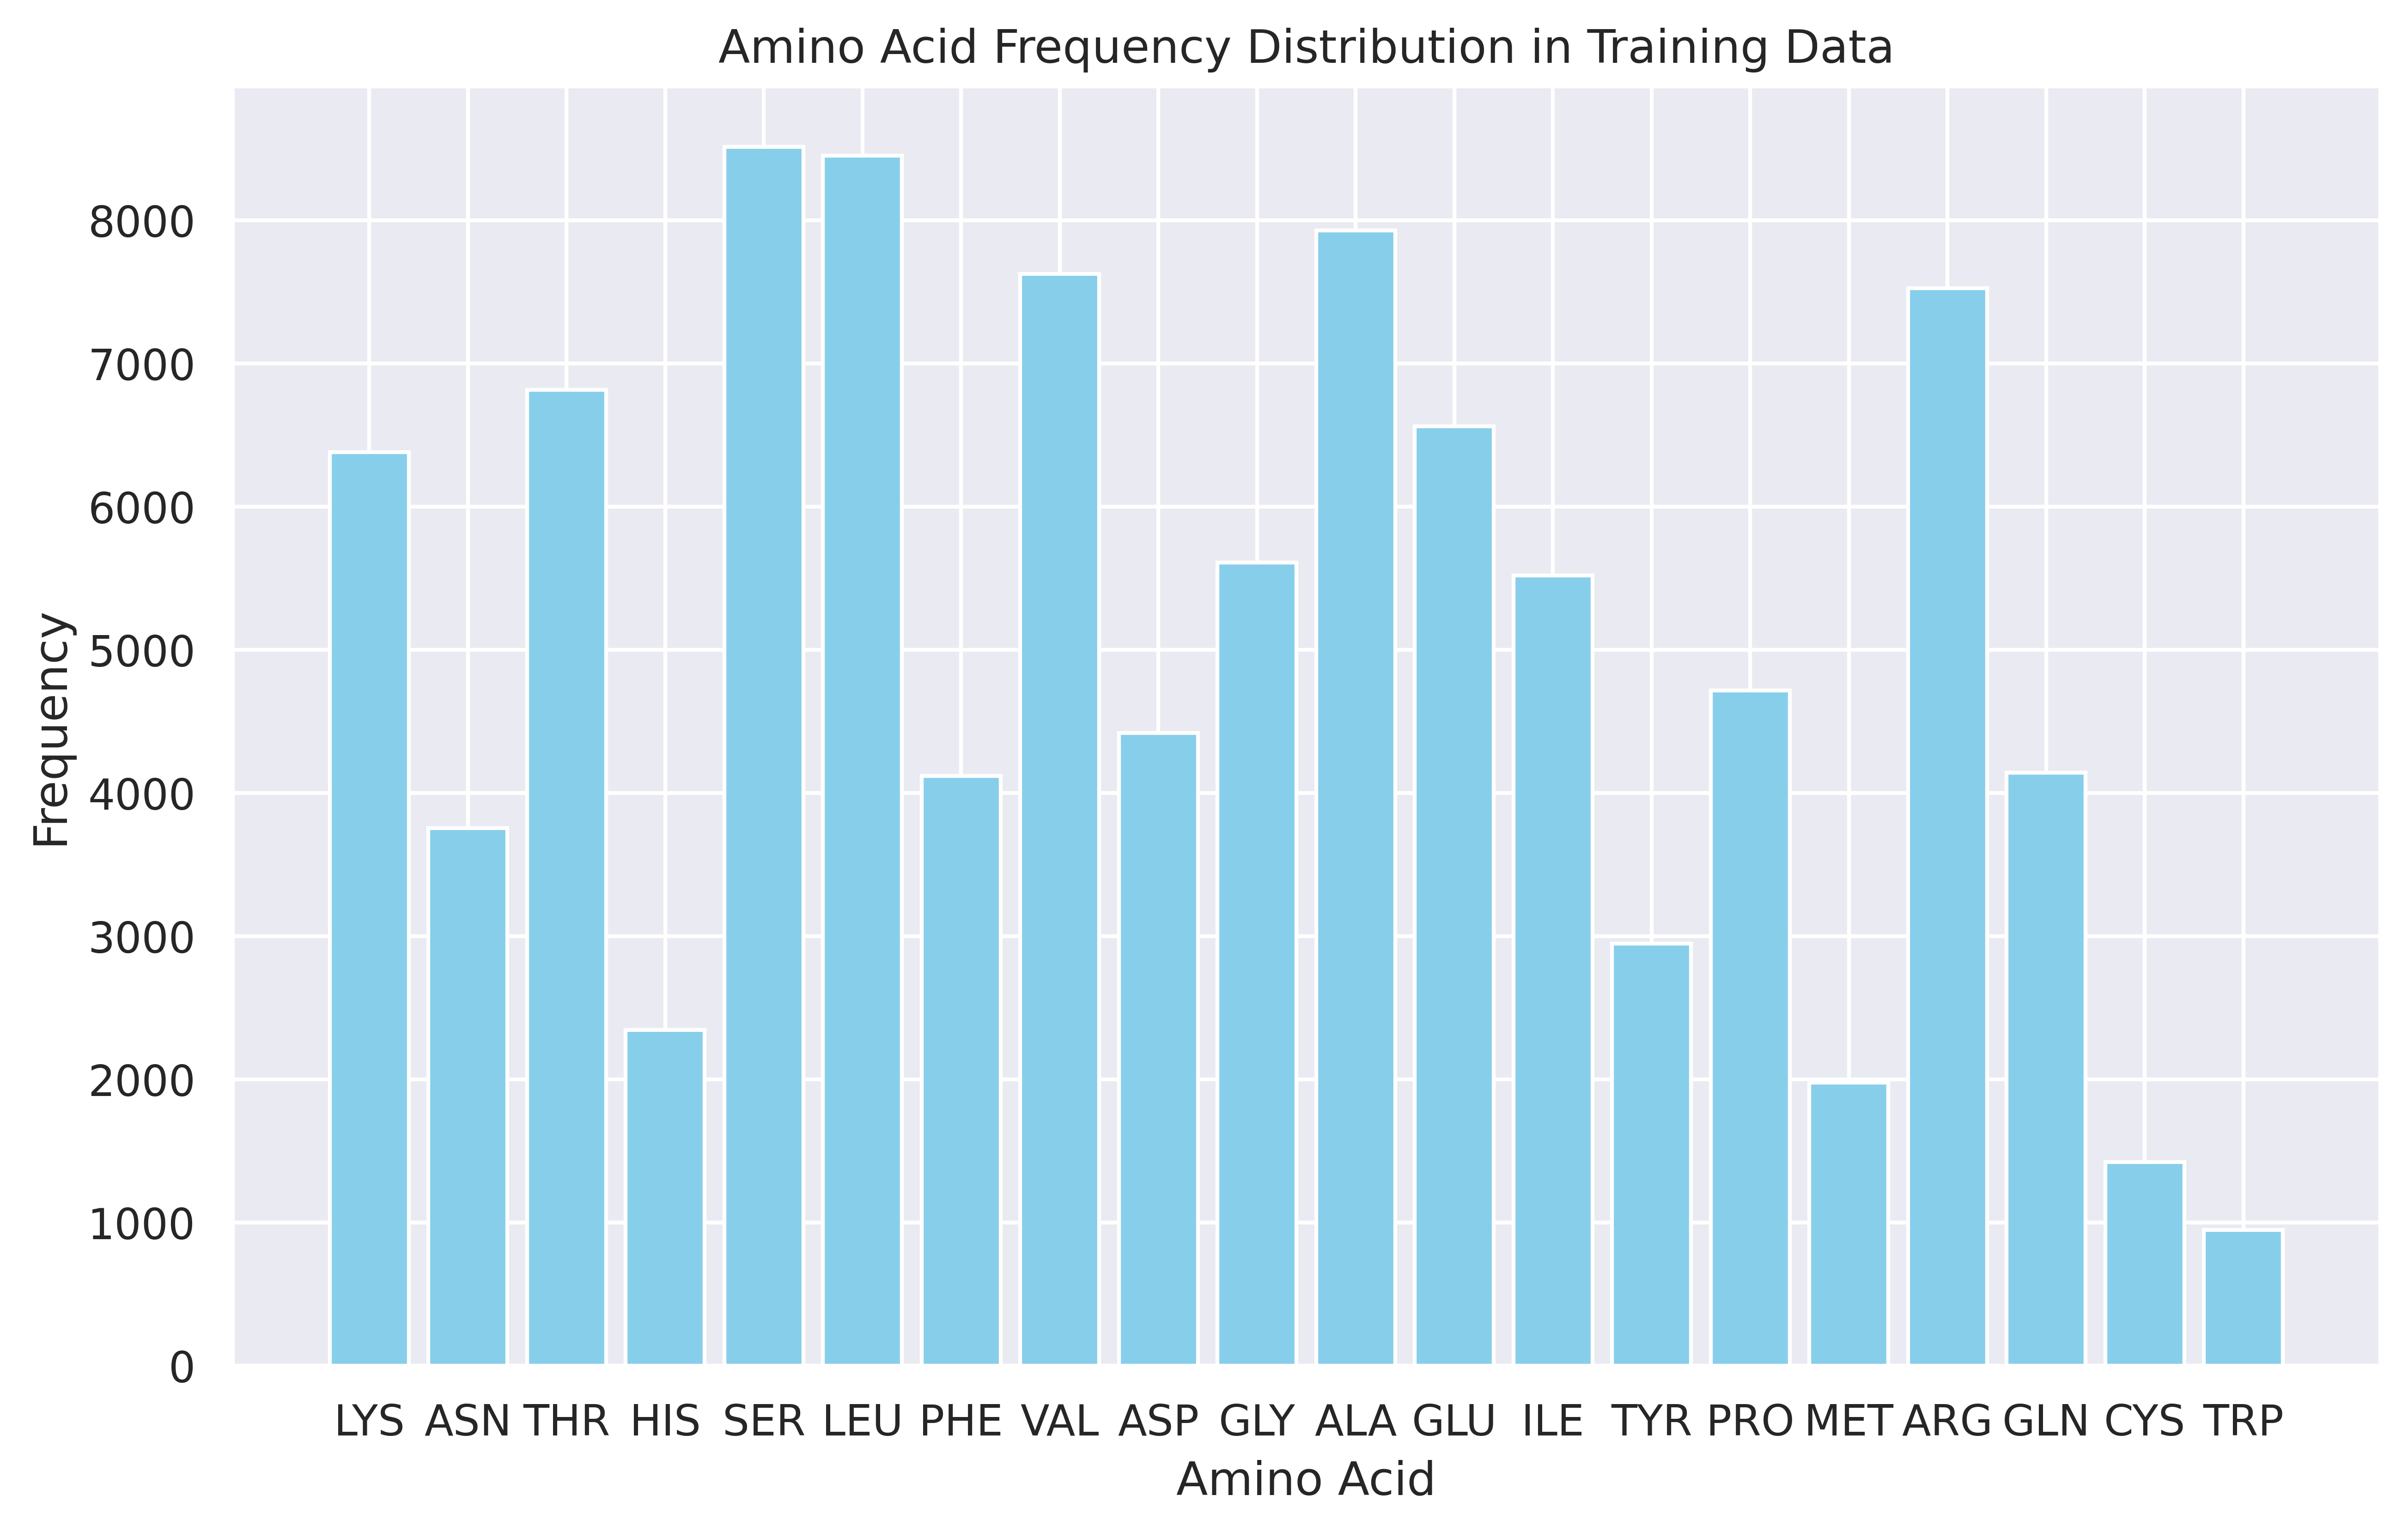

In [36]:
# 统计氨基酸频率
amino_acid_counts = Counter(train_data["sub_name"])

# 将计数转换为 DataFrame 以便于可视化
amino_acid_freq_df = pd.DataFrame.from_dict(
    amino_acid_counts, orient="index", columns=["count"]
)
amino_acid_freq_df = amino_acid_freq_df.reset_index().rename(
    columns={"index": "amino_acid"}
)

# 可视化氨基酸频率分布
plt.figure(figsize=(10, 6), dpi=600)
plt.bar(amino_acid_freq_df["amino_acid"], amino_acid_freq_df["count"], color="skyblue")
plt.xlabel("Amino Acid")
plt.ylabel("Frequency")
plt.title("Amino Acid Frequency Distribution in Training Data")
plt.show()

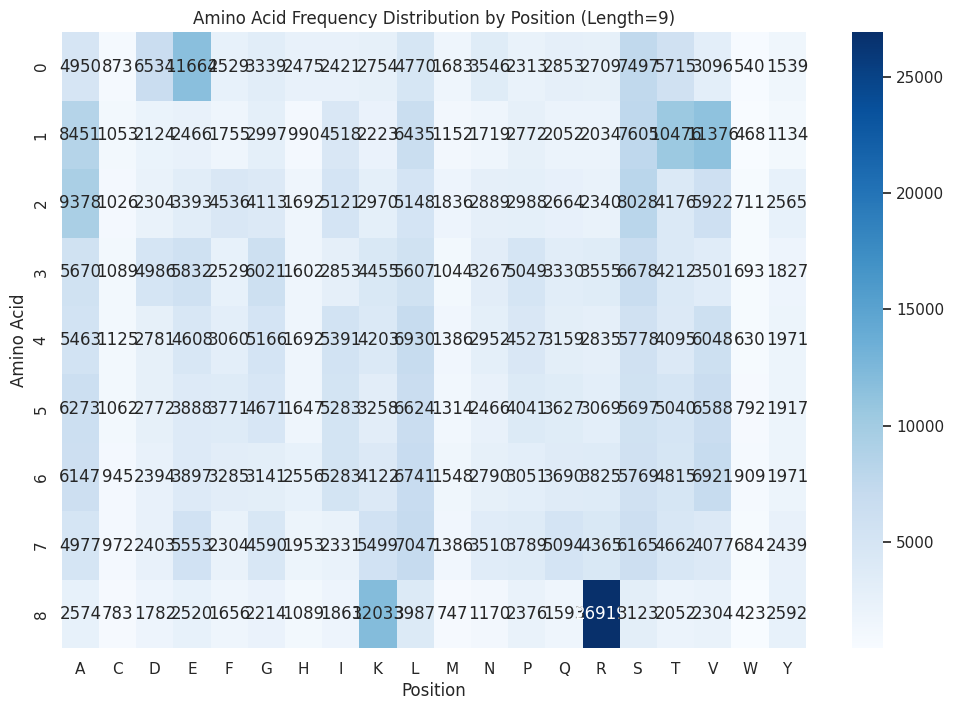

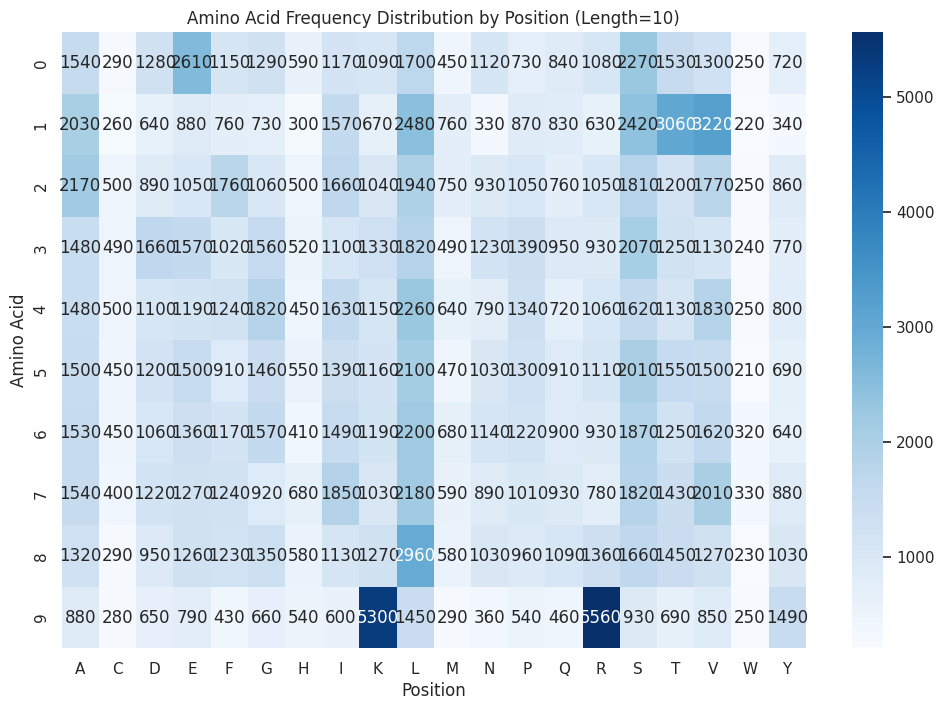

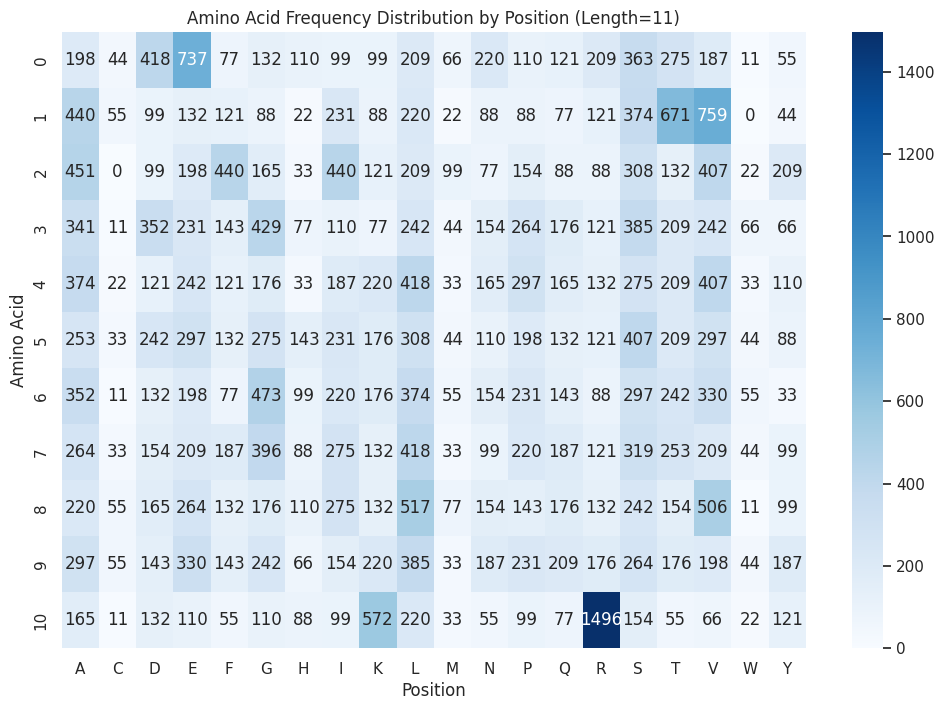

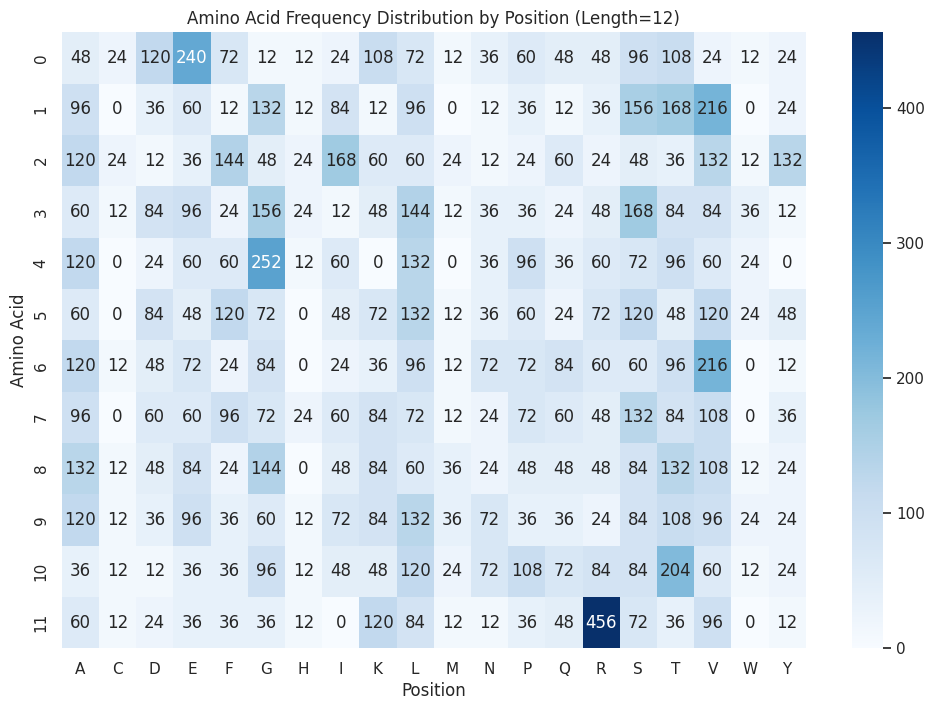

In [37]:
# 定义一个函数来统计每个位置上的氨基酸频率
def amino_acid_position_frequency(data, length):
    sequences = data[data['peptide_len'] == length]['sequence']
    position_counts = defaultdict(Counter)

    for seq in sequences:
        for i, aa in enumerate(seq):
            position_counts[i][aa] += 1

    # 转换为 DataFrame
    freq_matrix = pd.DataFrame(position_counts).fillna(0)
    freq_matrix = freq_matrix.sort_index().T  # 转置以便于绘制热力图
    freq_matrix = freq_matrix.reindex(sorted(freq_matrix.columns), axis=1)  # 按列名排序

    return freq_matrix

# 可视化氨基酸频率分布的热力图
def plot_heatmap(freq_matrix, length):
    plt.figure(figsize=(12, 8))
    sns.heatmap(freq_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=True)
    plt.xlabel('Position')
    plt.ylabel('Amino Acid')
    plt.title(f'Amino Acid Frequency Distribution by Position (Length={length})')
    plt.show()

matrix_dict = {}
for length in [9, 10, 11, 12]:
    freq_matrix = amino_acid_position_frequency(train_data, length)
    plot_heatmap(freq_matrix, length)
    matrix_dict[length] = freq_matrix

In [38]:
peptide = Peptide("SSMTIREFPR", methods="linear")
sequence = peptide.sequence
index = data[data["sequence"] == sequence].index.tolist()
smask_index = return_smask_index_i(smask_index_list, index)

attribution = data[data["sequence"] == sequence].attribution_normalized.tolist()
label = data[data["sequence"] == sequence].label.tolist()

attribution_sorted = [
        i for _, i in sorted(zip(attribution, attribution), reverse=False)
    ]
smask_index_sorted = [
        i for _, i in sorted(zip(attribution, smask_index), reverse=False)
    ]

# Show Top-n results
topx = 1
n = min([topx, len(attribution_sorted)])
pprint(peptide)
pprint(f"smask_index len: {len(smask_index)}: {[len(x) for x in smask_index]}")
pprint(f"Top-{topx} was assigned")
pprint(f"The max len is {len(attribution_sorted)}")
pprint(f"The exact number of sample is {n}")

SSMTIREFPR
'smask_index len: 10: [6, 6, 8, 7, 8, 11, 9, 11, 7, 12]'
'Top-1 was assigned'
'The max len is 10'
'The exact number of sample is 1'


In [39]:
# 计算多肽的贡献度
(
        attribution_list,
        atom_list,
        bond_attribution_list,
        bond_list,
        ring_attribution_list,
        ring_list,
    ) = return_atom_and_sub_attribution(
        peptide, smask_index_sorted, attribution_sorted
)

[[12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26], [6, 7, 8, 9, 10, 11], [27, 28, 29, 30, 31, 32, 33, 34], [0, 1, 2, 3, 4, 5], [46, 47, 48, 49, 50, 51, 52, 53, 54], [66, 67, 68, 69, 70, 71, 72], [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]] [-0.027618410149686, -0.027618410149686, -0.027618410149686, -0.027618410149686, -0.027618410149686, -0.027618410149686, -0.027618410149686, -0.027618410149686, -0.0230762038633371, -0.0230762038633371, -0.0230762038633371, -0.0230762038633371, -0.0230762038633371, -0.0230762038633371, -0.0230762038633371, -0.020296140447889, -0.020296140447889, -0.020296140447889, -0.020296140447889, -0.020296140447889, -0.020296140447889, -0.0188992405310897, -0.0188992405310897, -0.0188992405310897, -0.0188992405310897, -0.0188992405310897, -0.0188992405310897, -0.0188992405310897, -0.0188992405310897, -0.0165371182049918, -0.0165371182049918, -0.01653711

In [40]:
data[data["sequence"] == sequence]

,sequence,smiles,label,sub_name,group,sub_pred_mean,sub_pred_std,mol_pred_mean,mol_pred_std,attribution,attribution_normalized,smask_index_list,peptide_len
38,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,SER,train,0.983647,0.008645,0.967108,0.015683,-0.016539,-0.016537,"[0, 1, 2, 3, 4, 5]",10
39,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,SER,train,0.987407,0.007881,0.967108,0.015683,-0.020299,-0.020296,"[6, 7, 8, 9, 10, 11]",10
40,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,MET,train,0.994734,0.003461,0.967108,0.015683,-0.027625,-0.027618,"[12, 13, 14, 15, 16, 17, 18, 19]",10
41,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,THR,train,0.990188,0.006037,0.967108,0.015683,-0.023080,-0.023076,"[20, 21, 22, 23, 24, 25, 26]",10
42,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,ILE,train,0.986010,0.009637,0.967108,0.015683,-0.018901,-0.018899,"[27, 28, 29, 30, 31, 32, 33, 34]",10
43,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,ARG,train,0.974904,0.015032,0.967108,0.015683,-0.007796,-0.007796,"[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]",10
44,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,GLU,train,0.981670,0.011736,0.967108,0.015683,-0.014562,-0.014561,"[46, 47, 48, 49, 50, 51, 52, 53, 54]",10
45,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,PHE,train,0.974953,0.009393,0.967108,0.015683,-0.007844,-0.007844,"[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]",10
46,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,PRO,train,0.981371,0.012911,0.967108,0.015683,-0.014263,-0.014262,"[66, 67, 68, 69, 70, 71, 72]",10
47,SSMTIREFPR,CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCSC)...,1.0,ARG,train,0.953424,0.014461,0.967108,0.015683,0.013685,0.013684,"[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]",10


In [41]:
print("prediction:", data[data["sequence"] == sequence].mol_pred_mean.tolist()[0])
print("label:", data[data["sequence"] == sequence].label.tolist()[0])
print("********Atribution********")

prediction: 0.967108166217804
label: 1.0
********Atribution********


[10:56:21] The new font size 1 is below the current minimum (6).


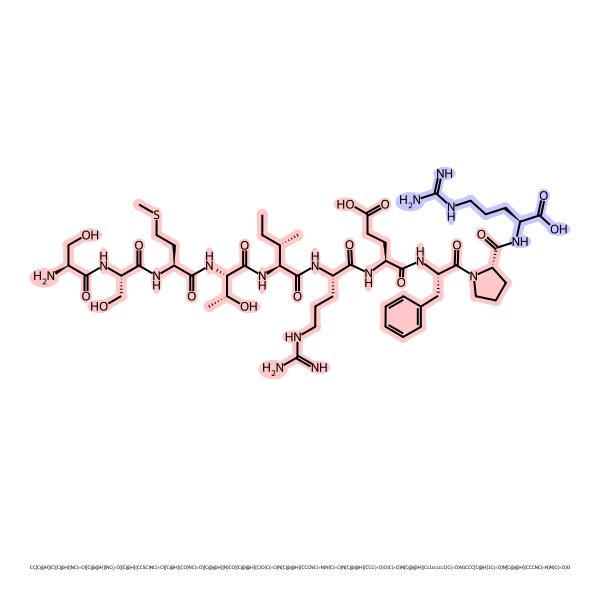

In [42]:
display(
        Image(
            sub_attribution_visualize(
                peptide,
                attribution_list,
                bond_attribution_list,
                ring_attribution_list,
                atom_list,
                bond_list,
                ring_list,
            )
        )
    )

## Attribution Scores

In [1]:
import numpy as np
import tmap as tm
import pandas as pd
from faerun import Faerun
from matplotlib import pyplot as plt
import dill
from core.models import AME
from core.utils import get_label, get_seg, Peptide
from functools import partial
from tqdm.auto import trange, tqdm
from pathlib import Path

/root/mambaforge/envs/pepexplainer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
task = "hla"

ame = AME(f"../config/ame_{task}.yml", checkpoints_dir="../model")

Args: {'task': 'hla', 'sub_type': 'aa', 'data_name': 'hla', 'label_name': 'target', 'peptide_name': 'peptide', 'methods': 'linear', 'max_workers': 16, 'in_feats': 40, 'max_evals': 30, 'loop': True, 'device': 'cuda', 'num_epochs': 500, 'report_epochs': 5, 'patience': 40, 'batch_size': 2048, 'rgcn_hidden_feats': [64, 64, 64, 64], 'ffn_hidden_feats': 128, 'rgcn_drop_out': 0.1, 'ffn_drop_out': 0.1, 'lr': 0.001, 'mode': 'higher', 'metric_name': 'accuracy', 'classification': True}


In [3]:
# 读取数据集
df = pd.read_csv(f"../data/{task}/origin_data/{task}.csv")
df.head()

,peptide,target,group
0,KKKNTHSLFV,0,train
1,TSFFDKGAV,0,train
2,EAIEGTYIDK,1,train
3,PGEGTPDGS,0,train
4,SSMTIREFPR,1,train


In [4]:
labels_file = Path(f"../tmp/tmap_{task}_labels.txt")
if labels_file.exists():
    with open(labels_file, "rb") as f:
        labels = dill.load(f)
else:
    labels = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        seq = row["peptide"]
        smi = Peptide(seq, methods="linear").smiles
        labels.append(str(smi) + "__name: " + str(seq) + f"__label: {row['target']}")
    # Save the preprocessed embeddings
    with open(labels_file, "wb") as f:
        dill.dump(labels, f)

In [5]:
# Load preprocessed embeddings if the file exists
embedding_file = Path(f"../tmp/tmap_{task}.pkl")
if embedding_file.exists():
    with open(embedding_file, "rb") as f:
        X = dill.load(f)
else:
    # Preallocate the list if you know the embedding size, e.g., embedding_size = 128
    embedding_size = 64  # Example size, change it to your actual embedding size.
    Xs = np.zeros((len(df["peptide"]), embedding_size))

    batch_size = 1024*5
    for i in range(0, len(df["peptide"]), batch_size):
        batch_seqs = df["peptide"][i:i+batch_size]
        embeddings = ame.get_embedding(batch_seqs)
        Xs[i:i+batch_size] = embeddings

    # Convert list of arrays into a 3D numpy array
    # If each embedding is 2D, then X will be a 3D array
    X = np.array(Xs)

    # Save the preprocessed embeddings
    with open(embedding_file, "wb") as f:
        dill.dump(X, f)

In [6]:
def prepare_data(X, df):
    """Prepare data for further operations."""
    fps = [tm.VectorFloat(x.tolist()) for x in X.astype(np.int32)]
    data = [tm.VectorFloat(x) for x in X]
    data = enc.batch_from_weight_array(data)
    return fps, data

def configure_layout():
    """Configure the layout."""
    cfg = tm.LayoutConfiguration()
    cfg.k = 50
    cfg.kc = 50
    cfg.sl_scaling_min = 1.0
    cfg.sl_scaling_max = 1.0
    cfg.sl_repeats = 1
    cfg.sl_extra_scaling_steps = 2
    cfg.placer = tm.Placer.Barycenter
    cfg.merger = tm.Merger.LocalBiconnected
    cfg.merger_factor = 2.0
    cfg.merger_adjustment = 0
    cfg.fme_iterations = 1000
    cfg.sl_scaling_type = tm.ScalingType.RelativeToDesiredLength
    cfg.node_size = 1 / 30
    cfg.mmm_repeats = 1
    return cfg

# Initialize encoders and structures
enc = tm.Minhash(64)
lf = tm.LSHForest(64, 64)

# Prepare data
fps, data = prepare_data(X, df)

# Update LSH Forest
lf.batch_add(data)
lf.index()

# Configure layout
cfg = configure_layout()
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

# Adjust colormap
tab_10 = plt.cm.get_cmap("tab10")

# Create categories
type_labels, type_data = Faerun.create_categories(df["target"])

# Plotting
f = Faerun(view="front", coords=False, clear_color="#FFFFFF")
from matplotlib.colors import ListedColormap
bin_cmap = ListedColormap(["#e74c3c", "#2ecc71"], name="bin_cmap")
f.add_scatter(
    "np_atlas",
    {
        "x": x,
        "y": y,
        "c": type_data,
        "labels": labels,
    },
    shader="smoothCircle",
    point_scale=4.0,
    legend_labels=type_labels,
    categorical=True,
    colormap=bin_cmap,
    has_legend=True,
)
f.add_tree("peptide_atlas_tree", {"from": s, "to": t}, point_helper="np_atlas")
f.plot(template="smiles")

/tmp/ipykernel_6667/1689098308.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab_10 = plt.cm.get_cmap("tab10")


/root/autodl-tmp/PepExplainer/notebooks/index.html

## Optimization

In [7]:
import matplotlib.cm as cm
import matplotlib

from rdkit import Chem, Geometry
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from core.models import AME
from core.utils import Peptide
from core.visualization import return_bond_sub_index

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from IPython.display import Image, display

In [8]:
plt.rcParams["figure.dpi"] = 600

In [9]:
def plot_bar(values, seq=None):
    # Generate a colormap that maps the values to colors
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    colors = [plt.cm.seismic_r(norm(value)) for value in values]
    # colors = [cmap(norm(value)) for value in values]

    # Create the vertical bars with corresponding colors
    fig, ax = plt.subplots(dpi=600)
    bars = ax.bar(range(len(values)), values, color=colors)

    # Add labels and title
    # ax.set_xlabel('Index')
    ax.set_ylabel('Attribution')
    # ax.set_title('Vertical Bar Chart with Value-Based Coloring')

    # Set the X-axis ticks to align with the values
    ax.set_xticks(range(len(values)))
    if seq:
        ax.set_xticklabels([f"{token}:{i}" for i, token in enumerate(seq)])

    # Add value labels for each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    # Optimize the layout
    plt.tight_layout()

    # Display the plot
    plt.show()

def return_rings_attribution(mol, sub_index, sub_atom_attribution_list, fg=False):
    ring_index = [list(ring) for ring in Chem.GetSymmSSSR(mol)]
    # print(sub_index, sub_atom_attribution_list)
    ring_attribution_index = []

    # 官能团时，没有返回所有原子的 attribution,因此需要重新对应
    if fg:
        ring_attribution = []
        sub_atom_count = 0
        for sub in sub_index:
            ring_attribution.append(sub_atom_attribution_list[sub_atom_count])
            sub_atom_count = sub_atom_count + len(sub)

    # 判断环在哪个子结构中，并返回对应的 attribution
    final_ring_index = []
    for ring in ring_index:
        for i, sub in enumerate(sub_index):
            if len(list(set(ring).intersection(set(sub)))) > 0:
                if fg:
                    ring_attribution_index.append(ring_attribution[i])
                    final_ring_index.append(ring)
                else:
                    ring_attribution_index.append(sub_atom_attribution_list[sub[0]])
                    final_ring_index.append(ring)
    return final_ring_index, ring_attribution_index

def return_atom_and_sub_attribution(
    peptide,
    smask_index,
    attribution,
):
    """返回多肽的原子和子结构贡献度

    Args:
        peptide (Peptide): 多肽
        smask_index (_type_): 掩码索引
        attribution (_type_): 贡献度

    Returns:
        返回每一个贡献度列表
    """
    mol = peptide.mol

    # 为子结构每个原子添加 attribution
    attribution_list = []
    atom_list = []
    for i, sub in enumerate(smask_index):
        for atom_index in sub:
            attribution_list.append(attribution[i])
            atom_list.append(atom_index)

    # 为子结构每个环添加 attribution
    ring_list, ring_attribution_list = return_rings_attribution(
        mol, smask_index, attribution_list, fg=True
    )

    # 为子结构每个键添加 attribution
    bond_attribution_index_list = []
    for i in range(mol.GetNumBonds()):
        bond = mol.GetBondWithIdx(i)
        bond_idx = [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        bond_attribution_index_list.append(return_bond_sub_index(bond_idx, smask_index))

    # 为子结构找出包含的键，并给出 attribution
    bond_attribution_list = []
    bond_list = []
    for i, bond_attribution_index in enumerate(bond_attribution_index_list):
        if bond_attribution_index == -1:
            pass
        else:
            bond_list.append(i)
            bond_attribution_list.append(attribution[bond_attribution_index])

    return (
        attribution_list,
        atom_list,
        bond_attribution_list,
        bond_list,
        ring_attribution_list,
        ring_list,
    )

def sub_attribution_visualize(
    peptide,
    atom_attribution,
    bond_attribution,
    ring_attribution,
    atom_list=None,
    bond_list=None,
    ring_list=None,
    cmap_name="seismic_r",
):
    mol = peptide.mol
    smiles = peptide.smiles
    smiles = ""  # 让字体不显示
    cmap = cm.get_cmap(cmap_name, 10)
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)

    highlight_atom_colors = {}
    highlight_bond_colors = {}
    atomrads = {}
    widthmults = {}

    if atom_list is None:
        atom_list = range(0, mol.GetNumAtoms())
    if bond_list is None:
        bond_list = range(0, mol.GetNumBonds())

    for i in atom_list:
        highlight_atom_colors[i] = [
            plt_colors.to_rgba(float(atom_attribution[atom_list.index(i)]))
        ]
        atomrads[atom_list.index(i)] = 0.2

    if len(bond_list) > 0:
        for i in bond_list:
            highlight_bond_colors[i] = [
                plt_colors.to_rgba(float(bond_attribution[bond_list.index(i)]))
            ]
            widthmults[bond_list.index(i)] = 1

    if len(ring_list) > 0:
        # ring_color = [
        #     plt_colors.to_rgba(float(ring_attribution[i]))
        #     for i in range(len(ring_list))
        # ]
        ring_color = [
            (240/256, 240/256, 240/256)
            for i in range(len(ring_list))
        ]  # 全部设置成灰色

    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DCairo(1200, 1200)
    dos = drawer.drawOptions()
    dos.useBWAtomPalette()  # 黑白分子
    drawer.SetFontSize(1)


    if len(ring_list) > 0:
        # a hack to set the molecule scale
        drawer.DrawMoleculeWithHighlights(
            mol,
            smiles,
            highlight_atom_colors,
            highlight_bond_colors,
            atomrads,
            widthmults,
        )
        drawer.ClearDrawing()
        conf = mol.GetConformer()
        for i in range(len(ring_list)):
            aring = ring_list[i]
            ring_colors_i = ring_color[i]
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            drawer.SetFillPolys(True)
            drawer.SetColour(ring_colors_i)
            drawer.DrawPolygon(ps)
        dos.clearBackground = False

    # now draw the molecule, with highlights:
    drawer.DrawMoleculeWithHighlights(
        mol, smiles, highlight_atom_colors, highlight_bond_colors, atomrads, widthmults
    )
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    # drawer.WriteDrawingText(f"{smiles}_{sub_type}.png")
    return png

In [11]:
task = "hla"
ame = AME(f"../config/ame_{task}.yml", checkpoints_dir="../model")

Args: {'task': 'hla', 'sub_type': 'aa', 'data_name': 'hla', 'label_name': 'target', 'peptide_name': 'peptide', 'methods': 'linear', 'max_workers': 16, 'in_feats': 40, 'max_evals': 30, 'loop': True, 'device': 'cuda', 'num_epochs': 500, 'report_epochs': 5, 'patience': 40, 'batch_size': 2048, 'rgcn_hidden_feats': [64, 64, 64, 64], 'ffn_hidden_feats': 128, 'rgcn_drop_out': 0.1, 'ffn_drop_out': 0.1, 'lr': 0.001, 'mode': 'higher', 'metric_name': 'accuracy', 'classification': True}


In [12]:
def visualize_peptide(peptide: str):
    sequence = peptide.sequence
    smask_index = peptide.structure
    (
        peptides,
        y_preds_mol_mean,
        y_preds_mol_std,
        y_preds_mask_mean,
        y_preds_mask_std,
        attribution_normalized,
    ) = ame.predict(sequence, verbose=False)
    attribution = attribution_normalized[0]
    
    attribution_sorted = [
        i
        for _, i in sorted(
            zip(attribution, attribution), reverse=False
        )
    ]
    smask_index_sorted = [
        i for _, i in sorted(zip(attribution, smask_index), reverse=False)
    ]
    print("Attribution: ", attribution)
    # 计算多肽的贡献度
    (
        attribution_list,
        atom_list,
        bond_attribution_list,
        bond_list,
        ring_attribution_list,
        ring_list,
    ) = return_atom_and_sub_attribution(peptide, smask_index_sorted, attribution_sorted)

    print(peptide)
    print("prediction:", y_preds_mol_mean[0])
    print("prediction_std:", y_preds_mol_std[0])
    print("mask_prediction:", y_preds_mask_mean[0])
    print("mask_prediction_std:", y_preds_mask_std[0])
    print("label:", None)
    print("********Atribution********")

    display(
        Image(
            sub_attribution_visualize(
                peptide,
                attribution_list,
                bond_attribution_list,
                ring_attribution_list,
                atom_list,
                bond_list,
                ring_list,
            )
        )
    )
    plot_bar(attribution, sequence)

/root/mambaforge/envs/pepexplainer/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Attribution:  [-0.54925865 -0.10549771 -0.02490597 -0.04385412 -0.12335502 -0.15824798
  0.06812394 -0.01008358  0.03375623  0.08188365]
PSDTRQMLFY
prediction: 0.11490043
prediction_std: 0.108012095
mask_prediction: [0.7322194  0.22079214 0.13981153 0.15878275 0.23888688 0.27448958
 0.04667076 0.12498434 0.08113138 0.03283307]
mask_prediction_std: [0.21139076 0.18004784 0.12450055 0.11915563 0.12351611 0.17610316
 0.04292491 0.08302772 0.0600508  0.02423203]
label: None
********Atribution********


/tmp/ipykernel_6667/2807886084.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 10)
[11:18:22] The new font size 1 is below the current minimum (6).


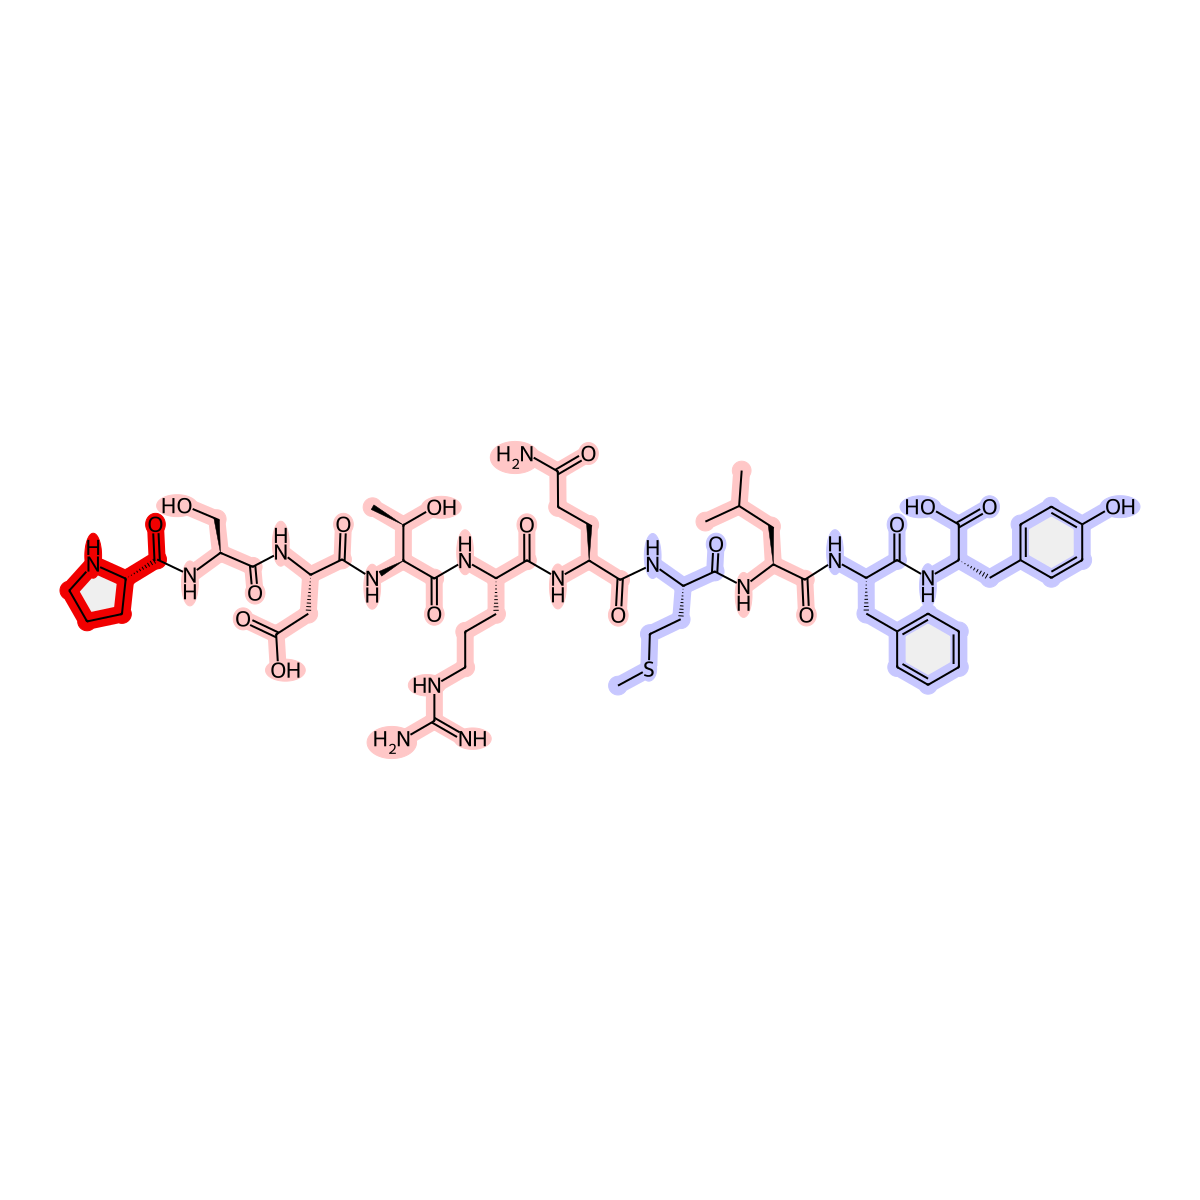

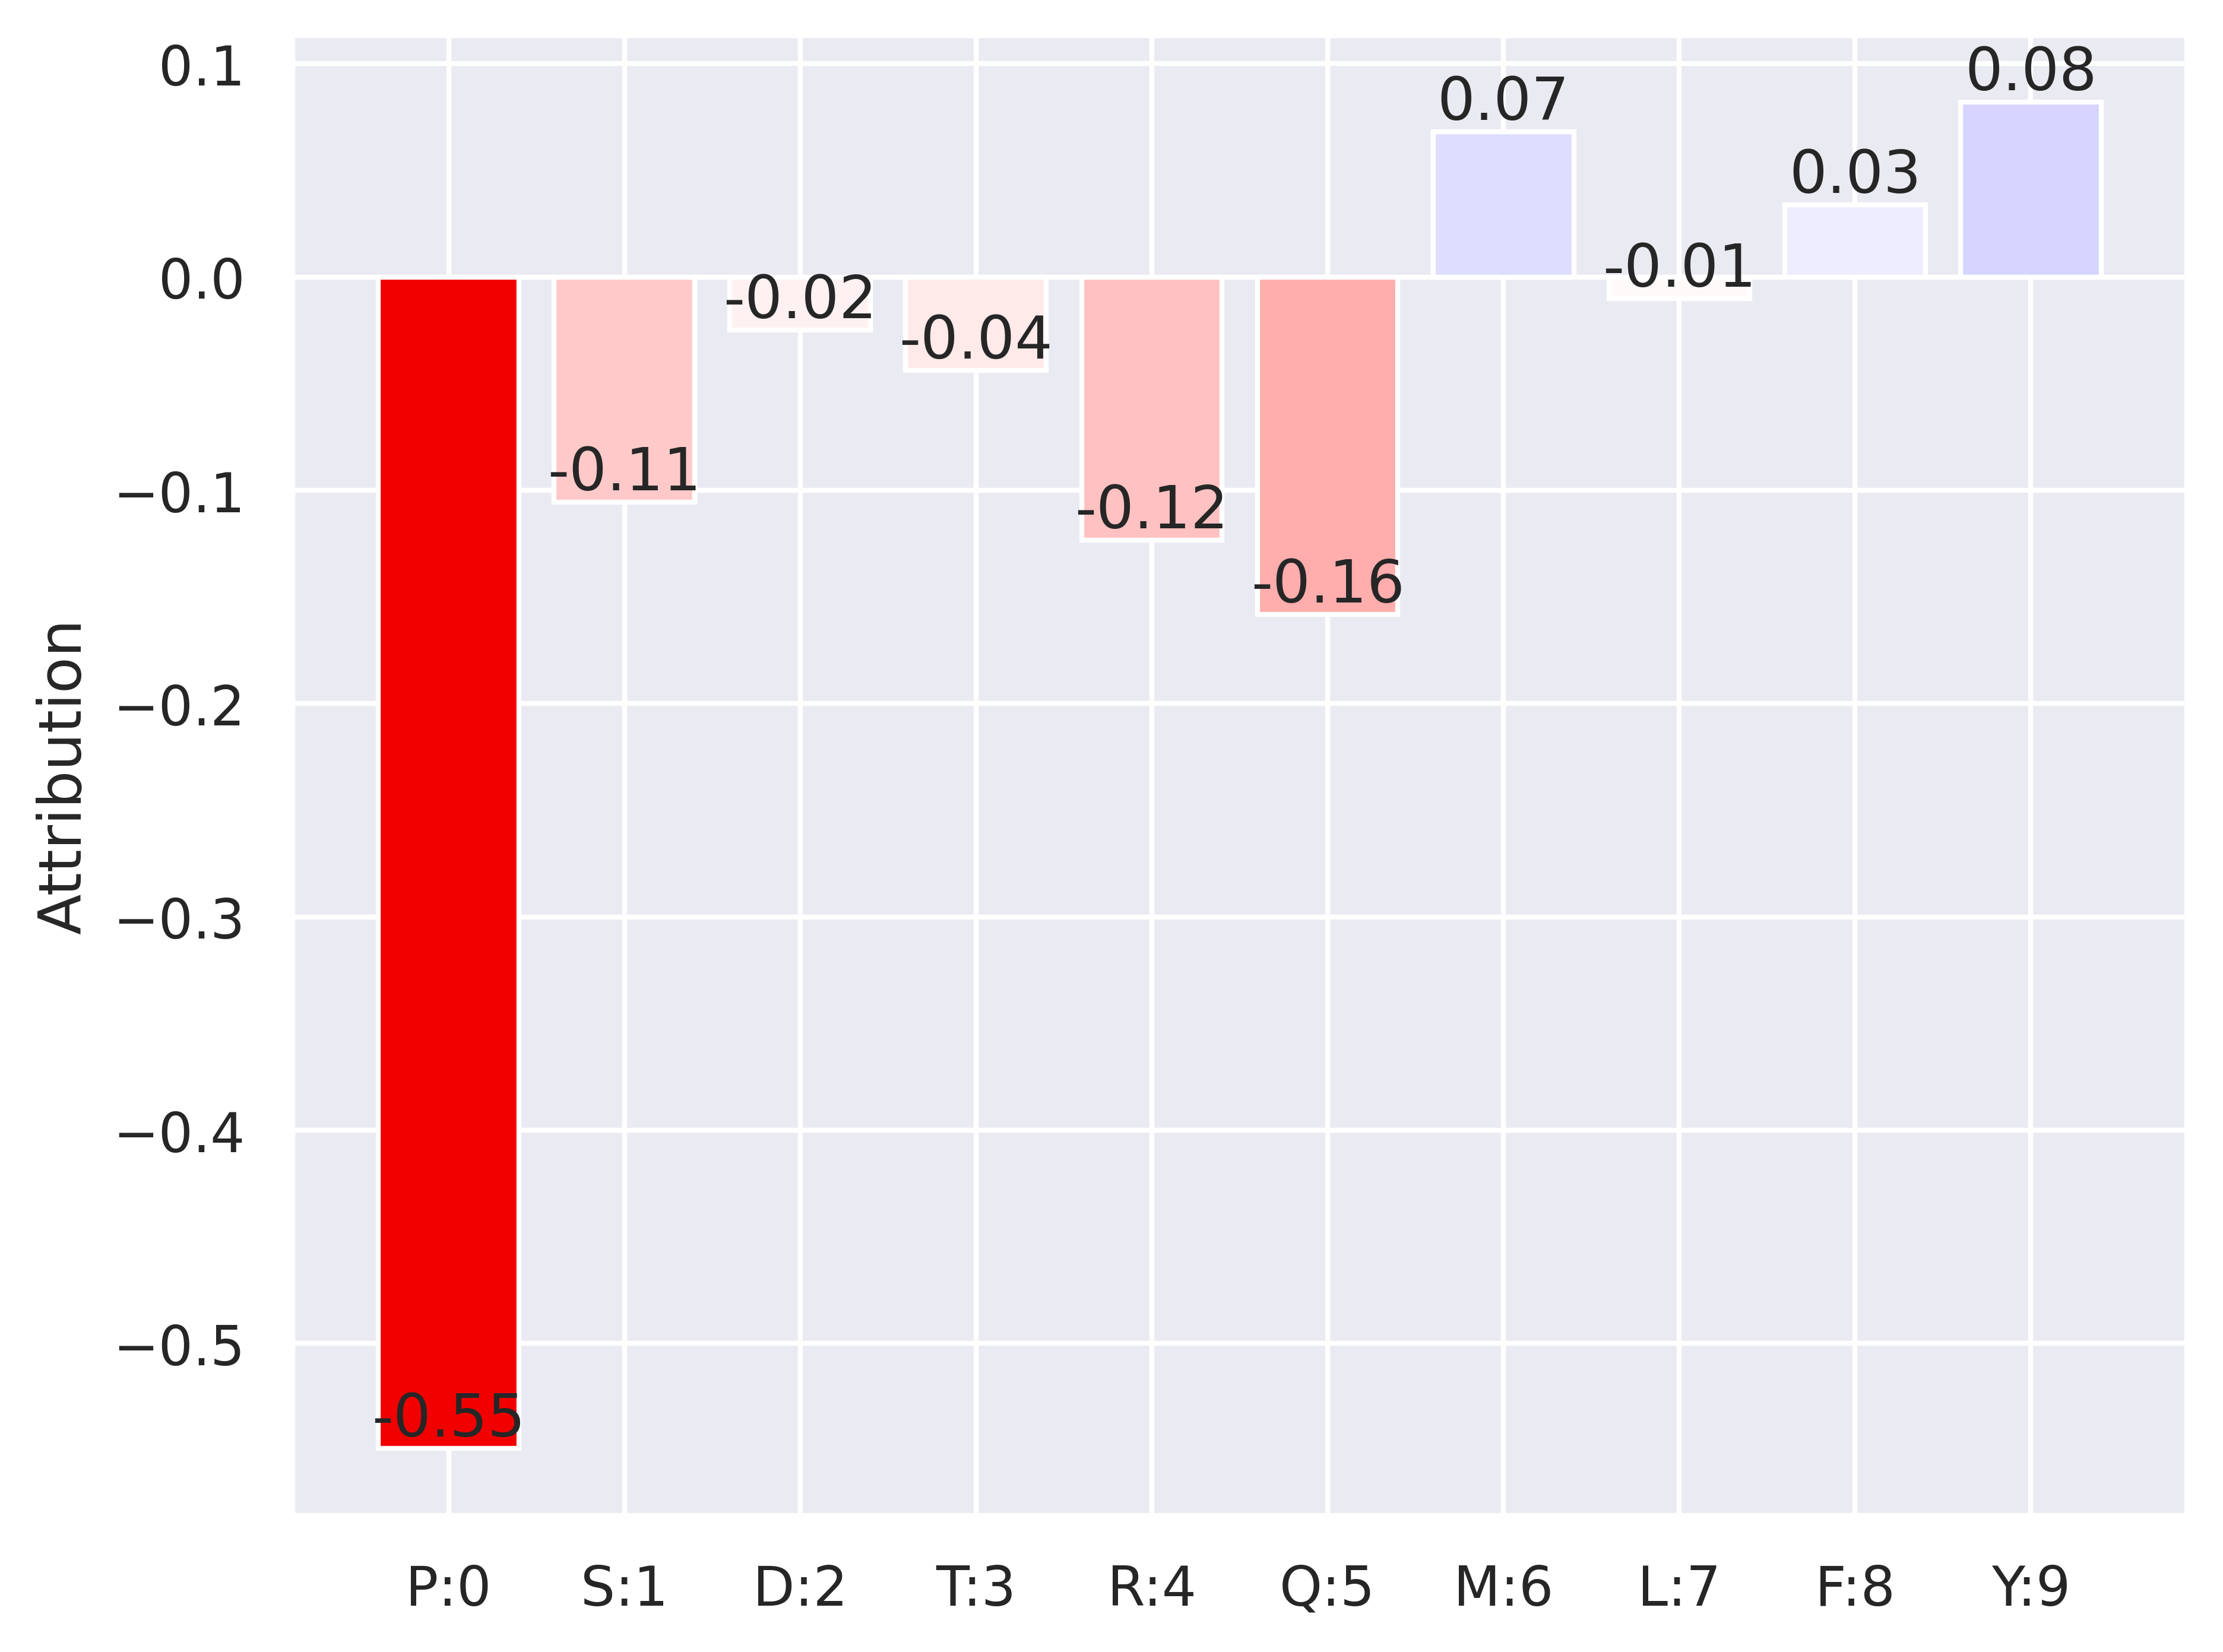

/root/mambaforge/envs/pepexplainer/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Attribution:  [ 0.01548513  0.01628103  0.01602131  0.01593173  0.01364846  0.01572668
  0.01607529  0.01615671 -0.00051481]
PSDTRQMLF
prediction: 0.017052678
prediction_std: 0.014537453
mask_prediction: [0.00156632 0.00077027 0.00102999 0.00111961 0.00340341 0.00132466
 0.00097598 0.00089458 0.01756748]
mask_prediction_std: [0.00212408 0.00080405 0.00131068 0.00169576 0.00501029 0.00185079
 0.00110027 0.00154222 0.01415928]
label: None
********Atribution********


/tmp/ipykernel_6667/2807886084.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 10)
[11:18:24] The new font size 1 is below the current minimum (6).


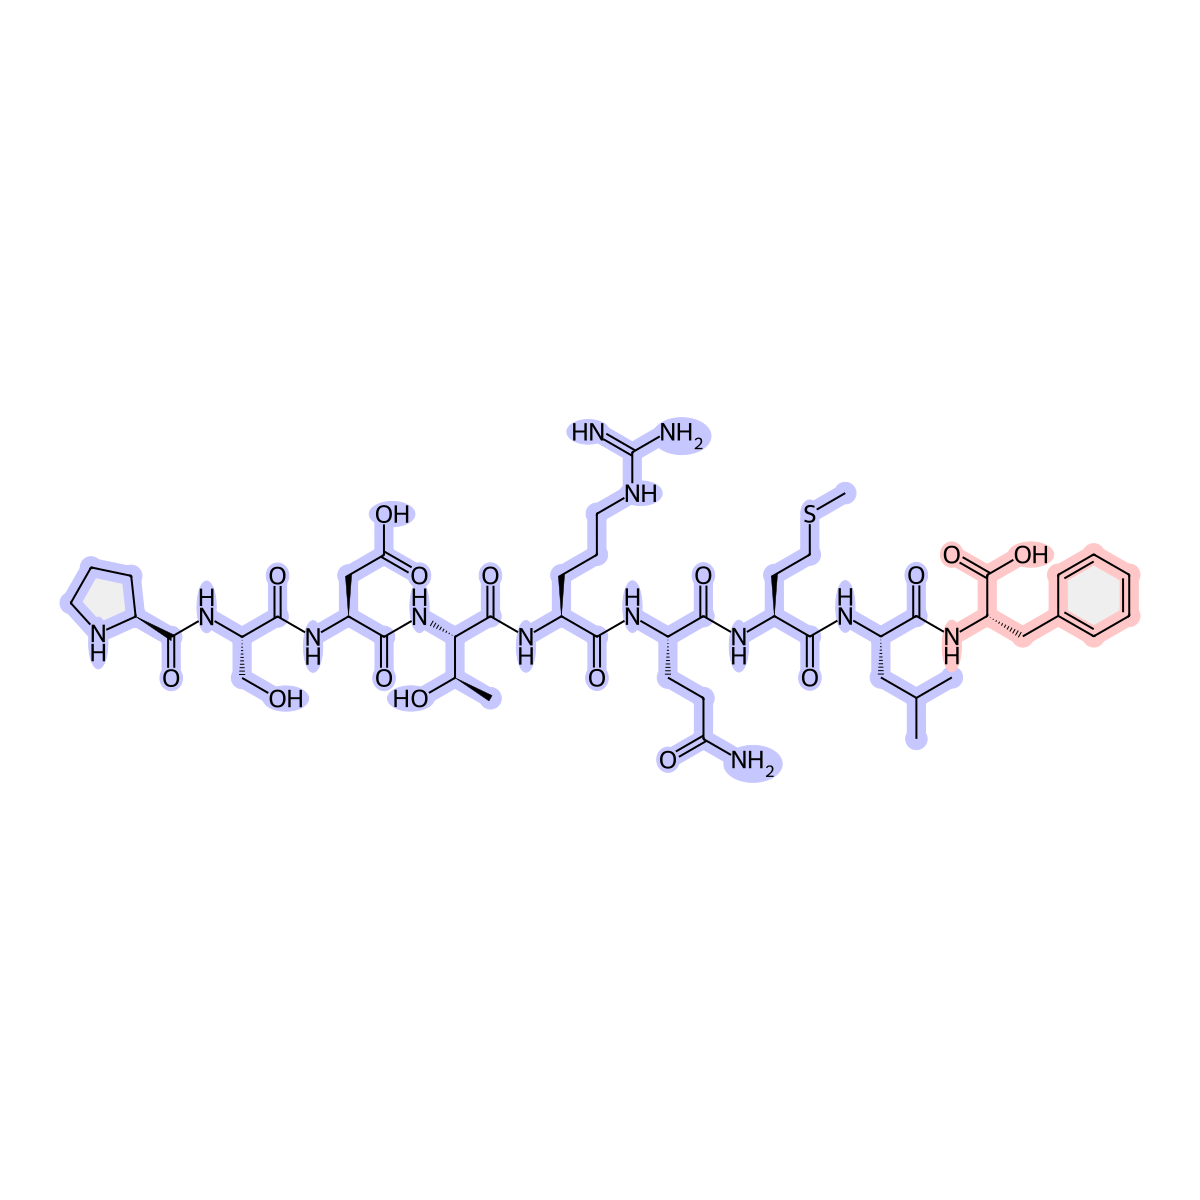

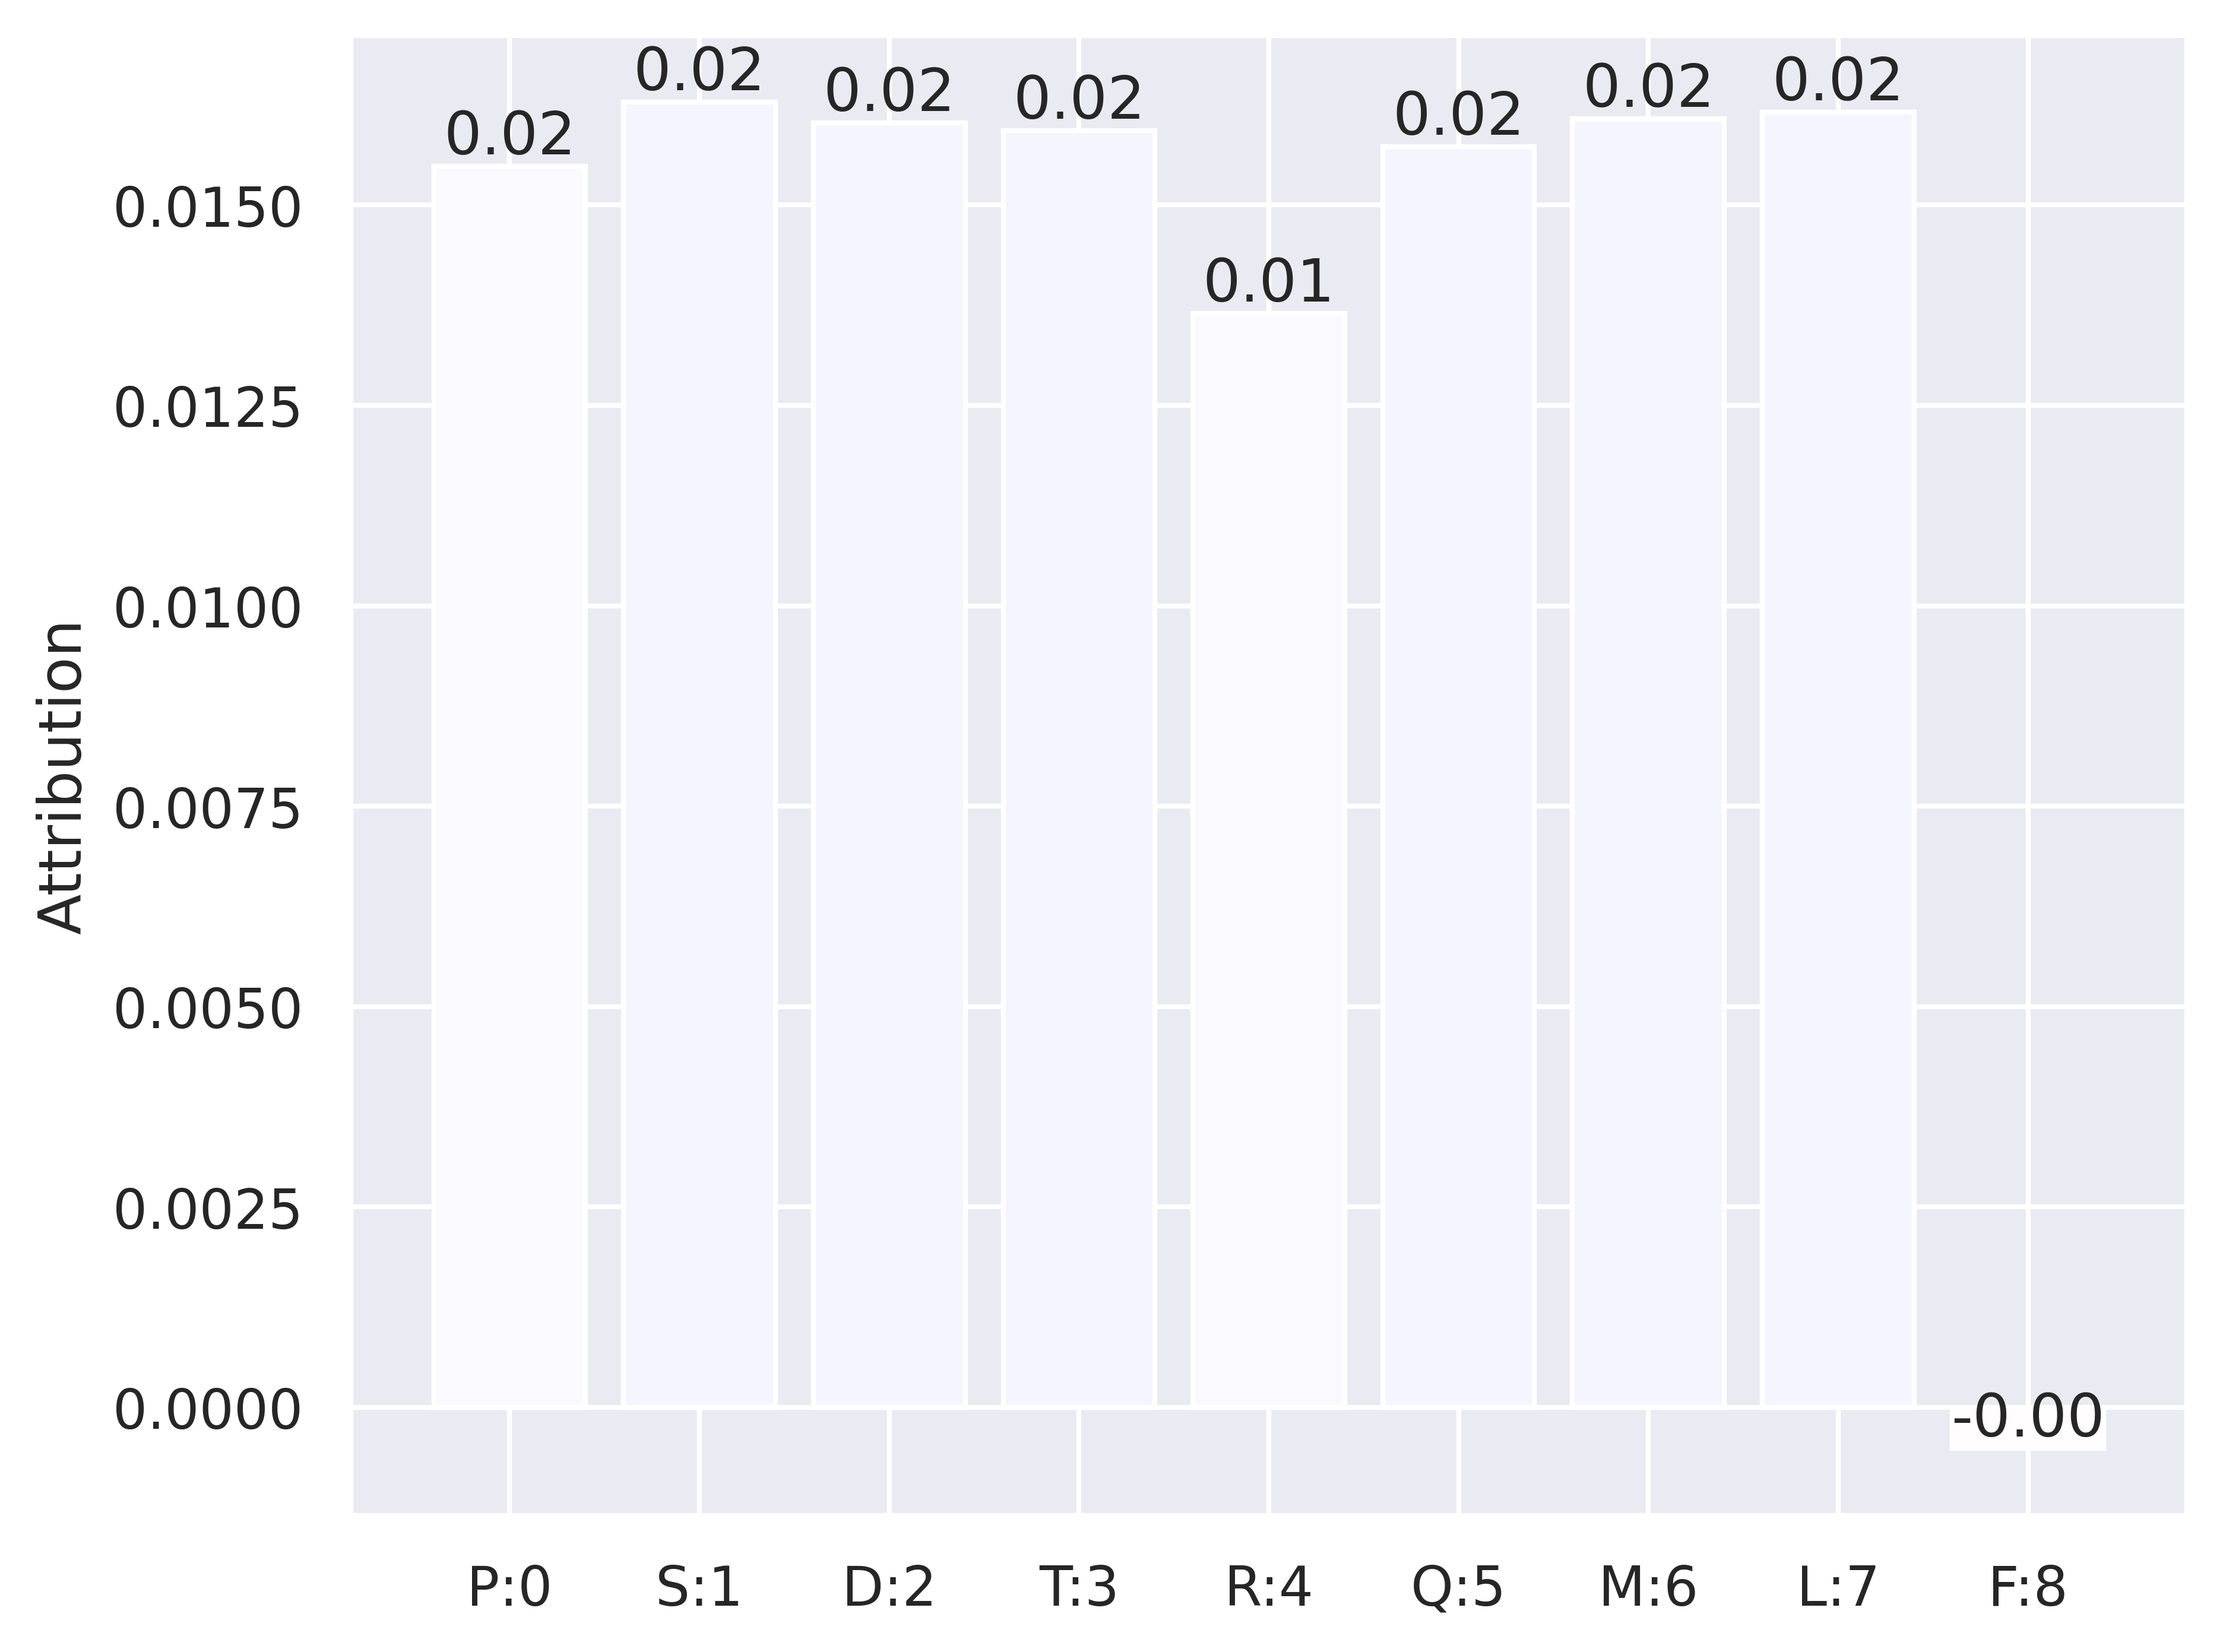

/root/mambaforge/envs/pepexplainer/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Attribution:  [ 0.03092198 -0.5150575  -0.04701883  0.05333932 -0.22438116  0.09255815
 -0.07600772  0.05425167  0.23159471]
SDTRQMLFY
prediction: 0.29303926
prediction_std: 0.1696337
mask_prediction: [0.2621074  0.86262846 0.34009278 0.23964922 0.521304   0.20021538
 0.36919385 0.23873428 0.05716532]
mask_prediction_std: [0.2427775  0.04436332 0.24006912 0.17765065 0.29015836 0.23214617
 0.2594914  0.19069804 0.05605709]
label: None
********Atribution********


/tmp/ipykernel_6667/2807886084.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 10)
[11:18:26] The new font size 1 is below the current minimum (6).


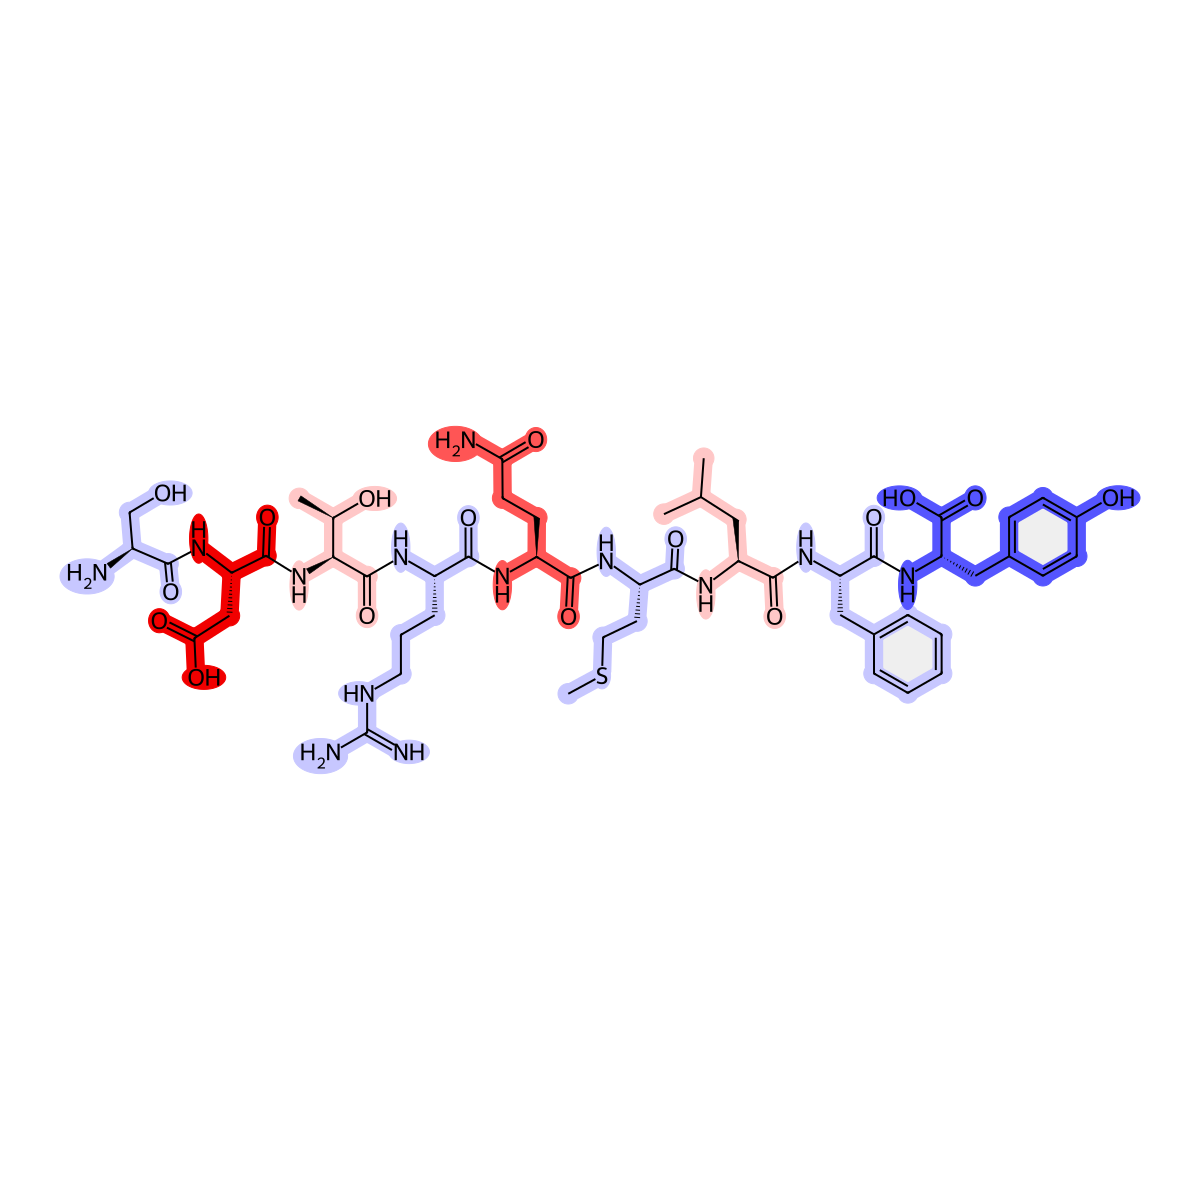

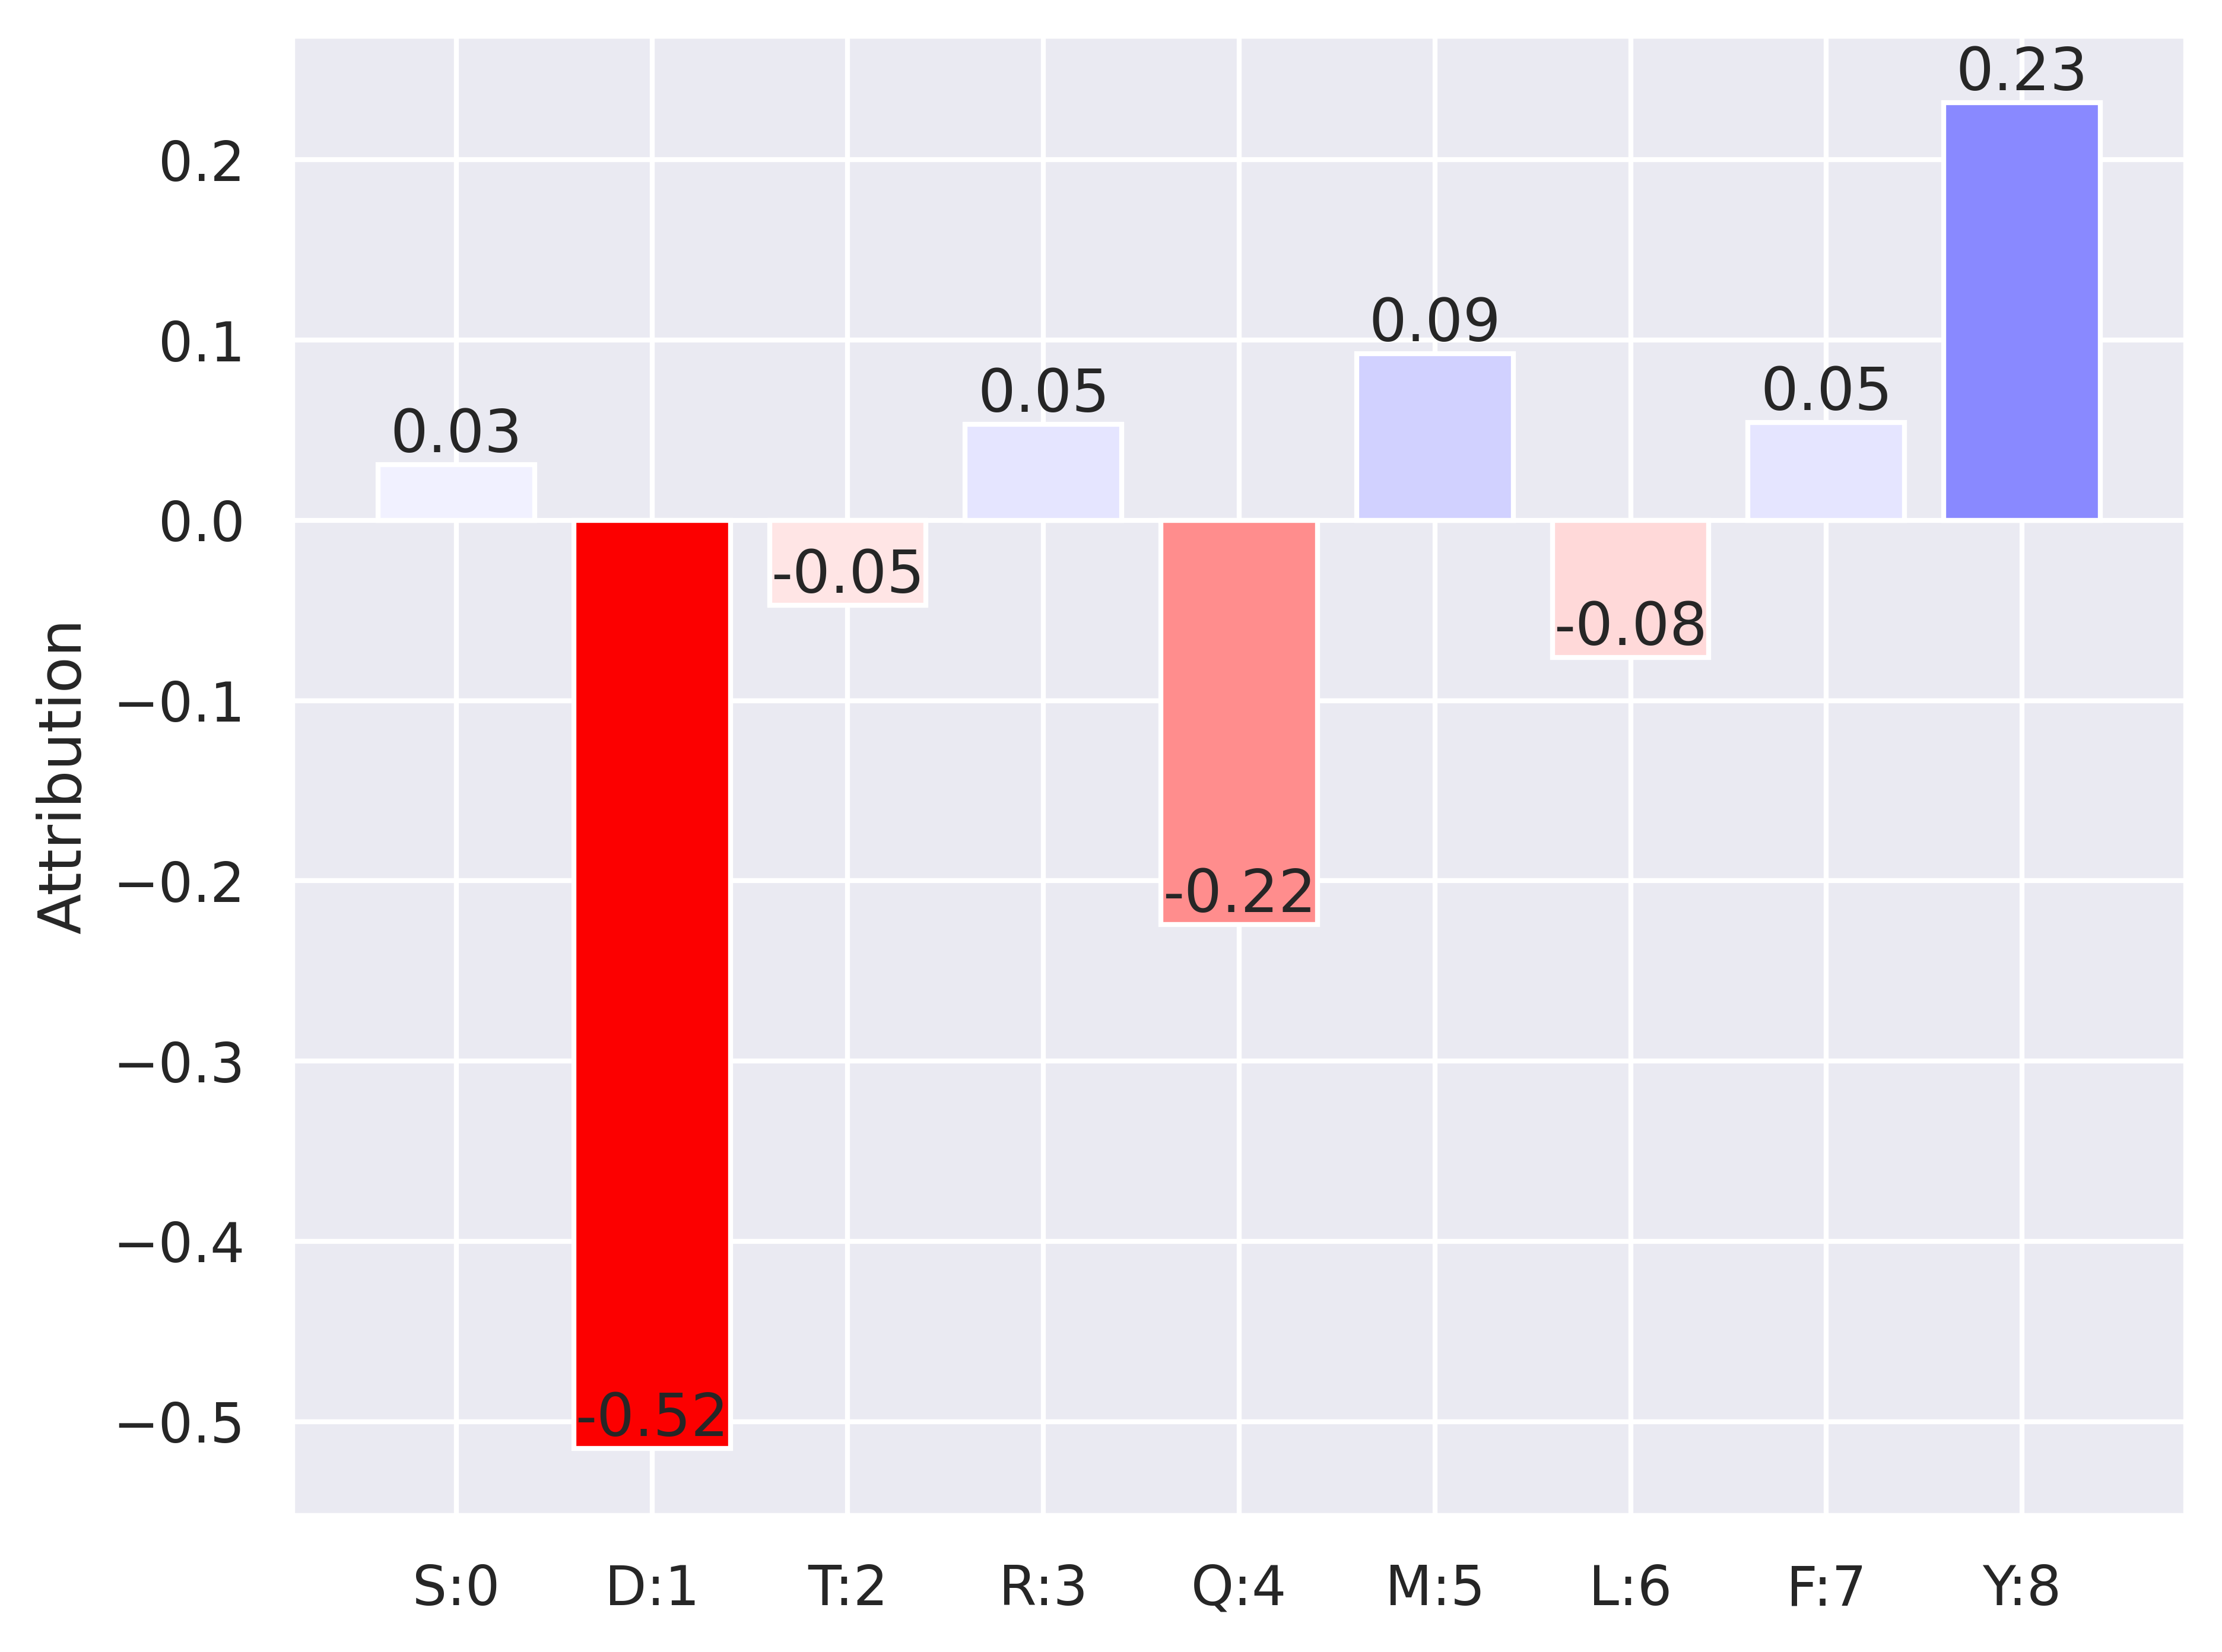

In [13]:
peptide_list = ["PSDTRQMLFY", "PSDTRQMLF", "SDTRQMLFY"]

for pep in peptide_list:
    visualize_peptide(Peptide(pep, "linear"))

/root/mambaforge/envs/pepexplainer/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Attribution:  [-0.05308649 -0.17121556 -0.09806193 -0.12293546 -0.17203943 -0.03957385
 -0.14308947  0.03169404  0.3428967 ]
SATRQMLFY
prediction: 0.7673165
prediction_std: 0.09238437
mask_prediction: [0.820453   0.94023514 0.86569464 0.89087695 0.9410841  0.806911
 0.9113947  0.73561186 0.40994495]
mask_prediction_std: [0.11762422 0.02911565 0.09312712 0.06453165 0.04065327 0.12599364
 0.07477169 0.206999   0.19391266]
label: None
********Atribution********


/tmp/ipykernel_6667/2807886084.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 10)
[11:18:31] The new font size 1 is below the current minimum (6).


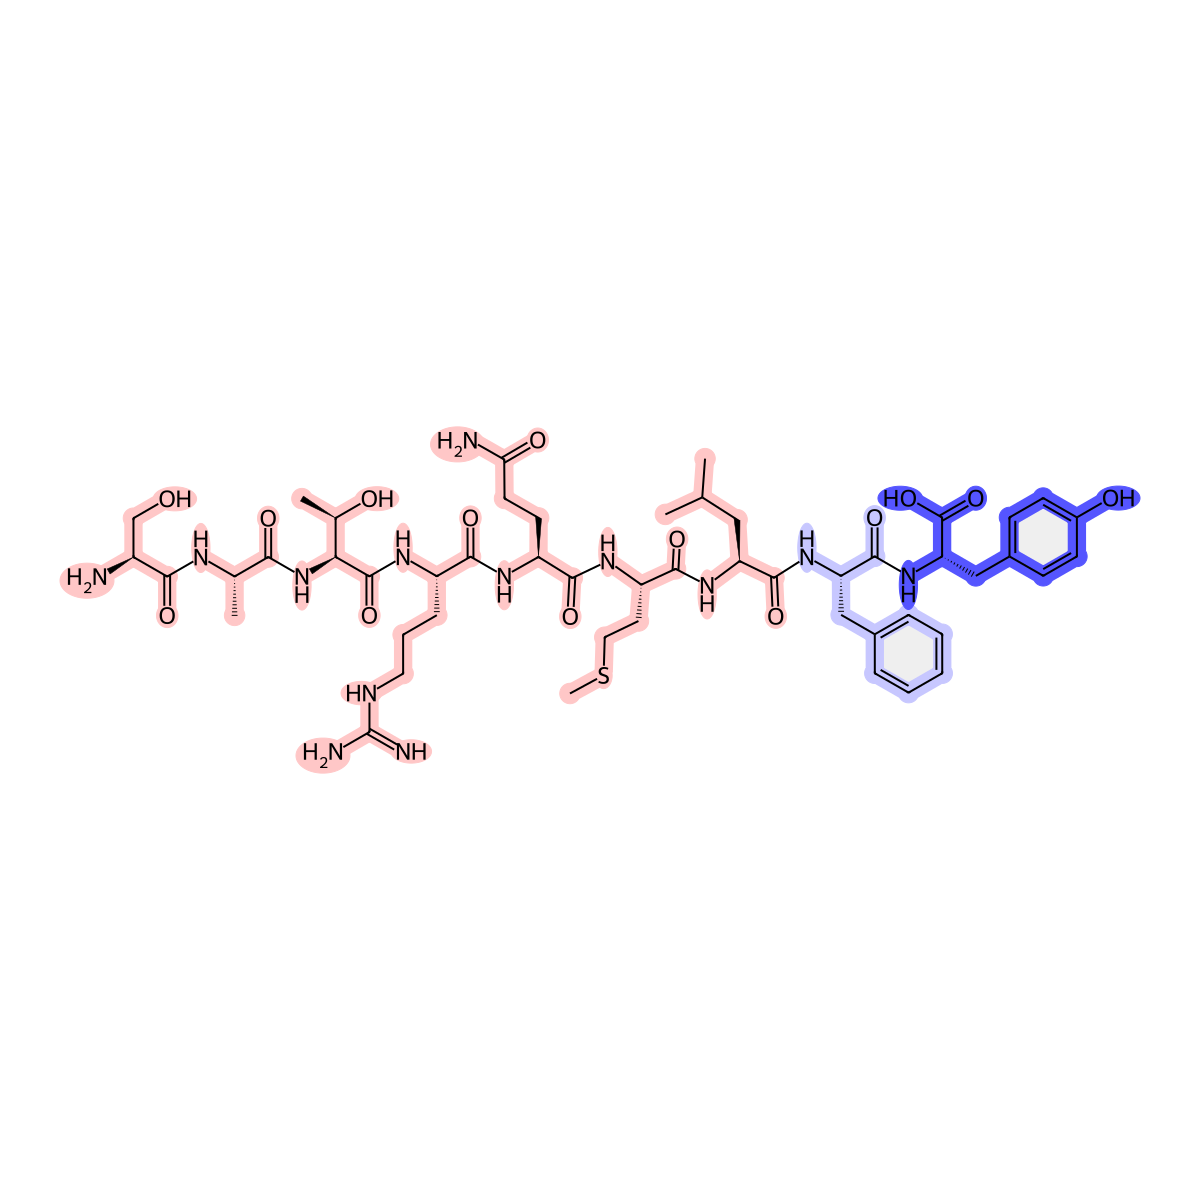

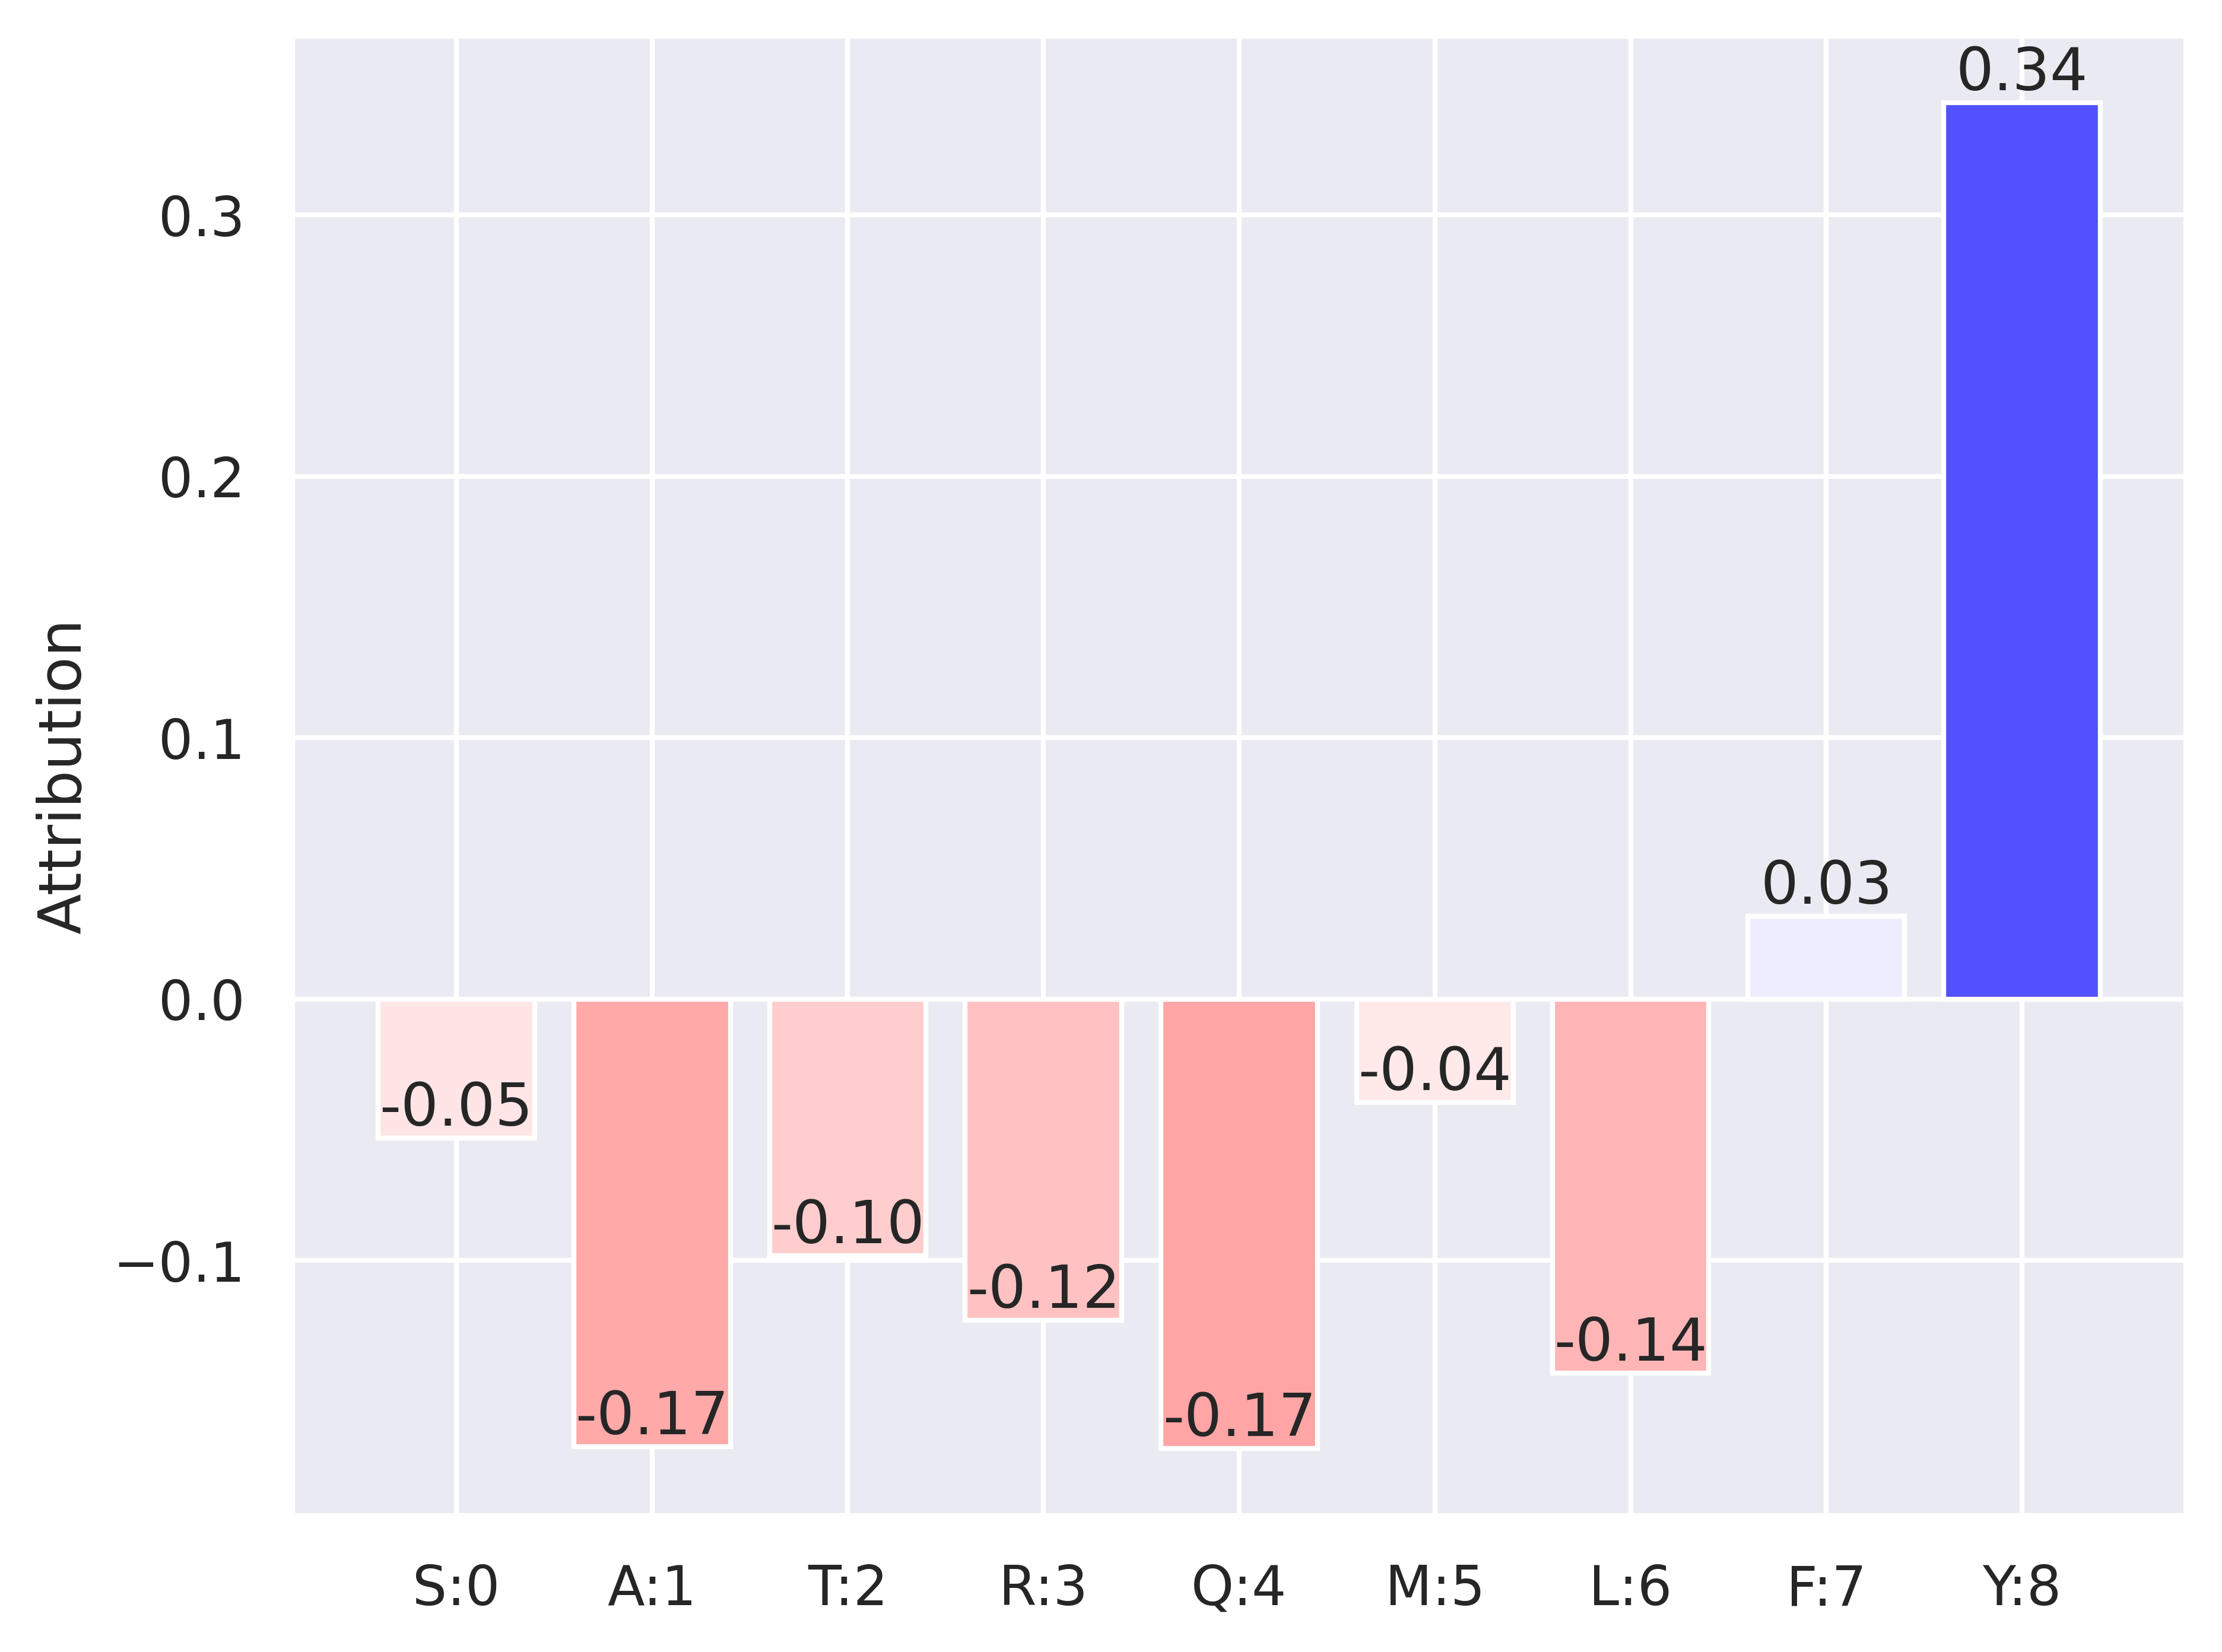

/root/mambaforge/envs/pepexplainer/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Attribution:  [-0.08014271 -0.15620677 -0.08699507 -0.11931072 -0.14446805 -0.04791879
 -0.1636343  -0.02367095  0.26277363]
DATRQMLFY
prediction: 0.76921
prediction_std: 0.11273127
mask_prediction: [0.849525   0.92670614 0.85642546 0.8890917  0.91469586 0.8171655
 0.9343287  0.79288536 0.5001246 ]
mask_prediction_std: [0.11380609 0.06015497 0.17998134 0.14924029 0.11537758 0.16014051
 0.06897768 0.15195741 0.21506019]
label: None
********Atribution********


/tmp/ipykernel_6667/2807886084.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 10)
[11:18:33] The new font size 1 is below the current minimum (6).


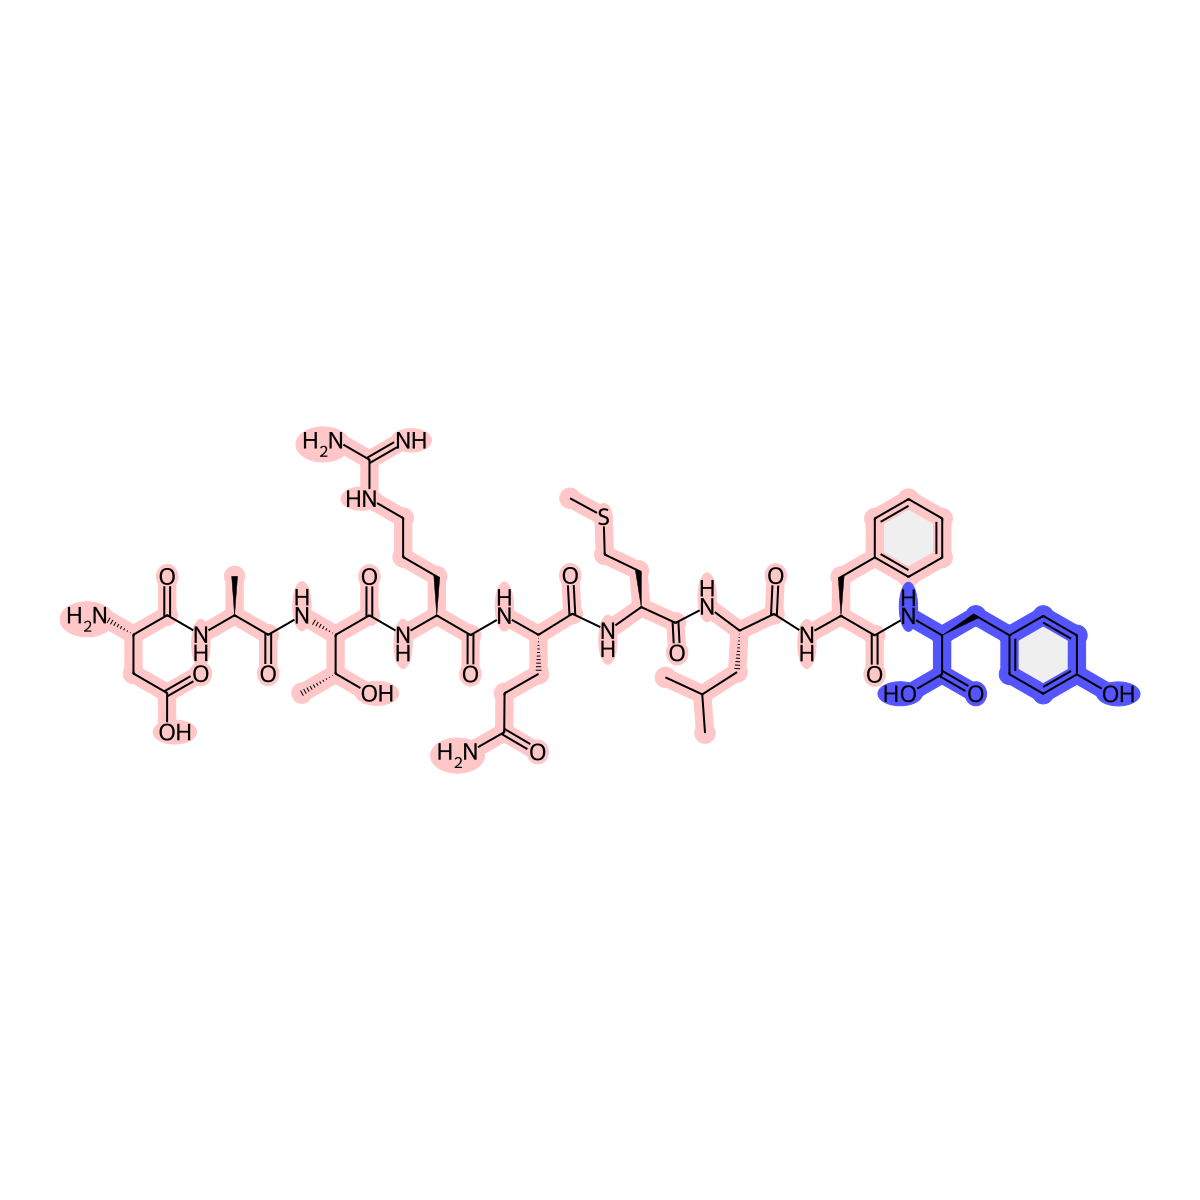

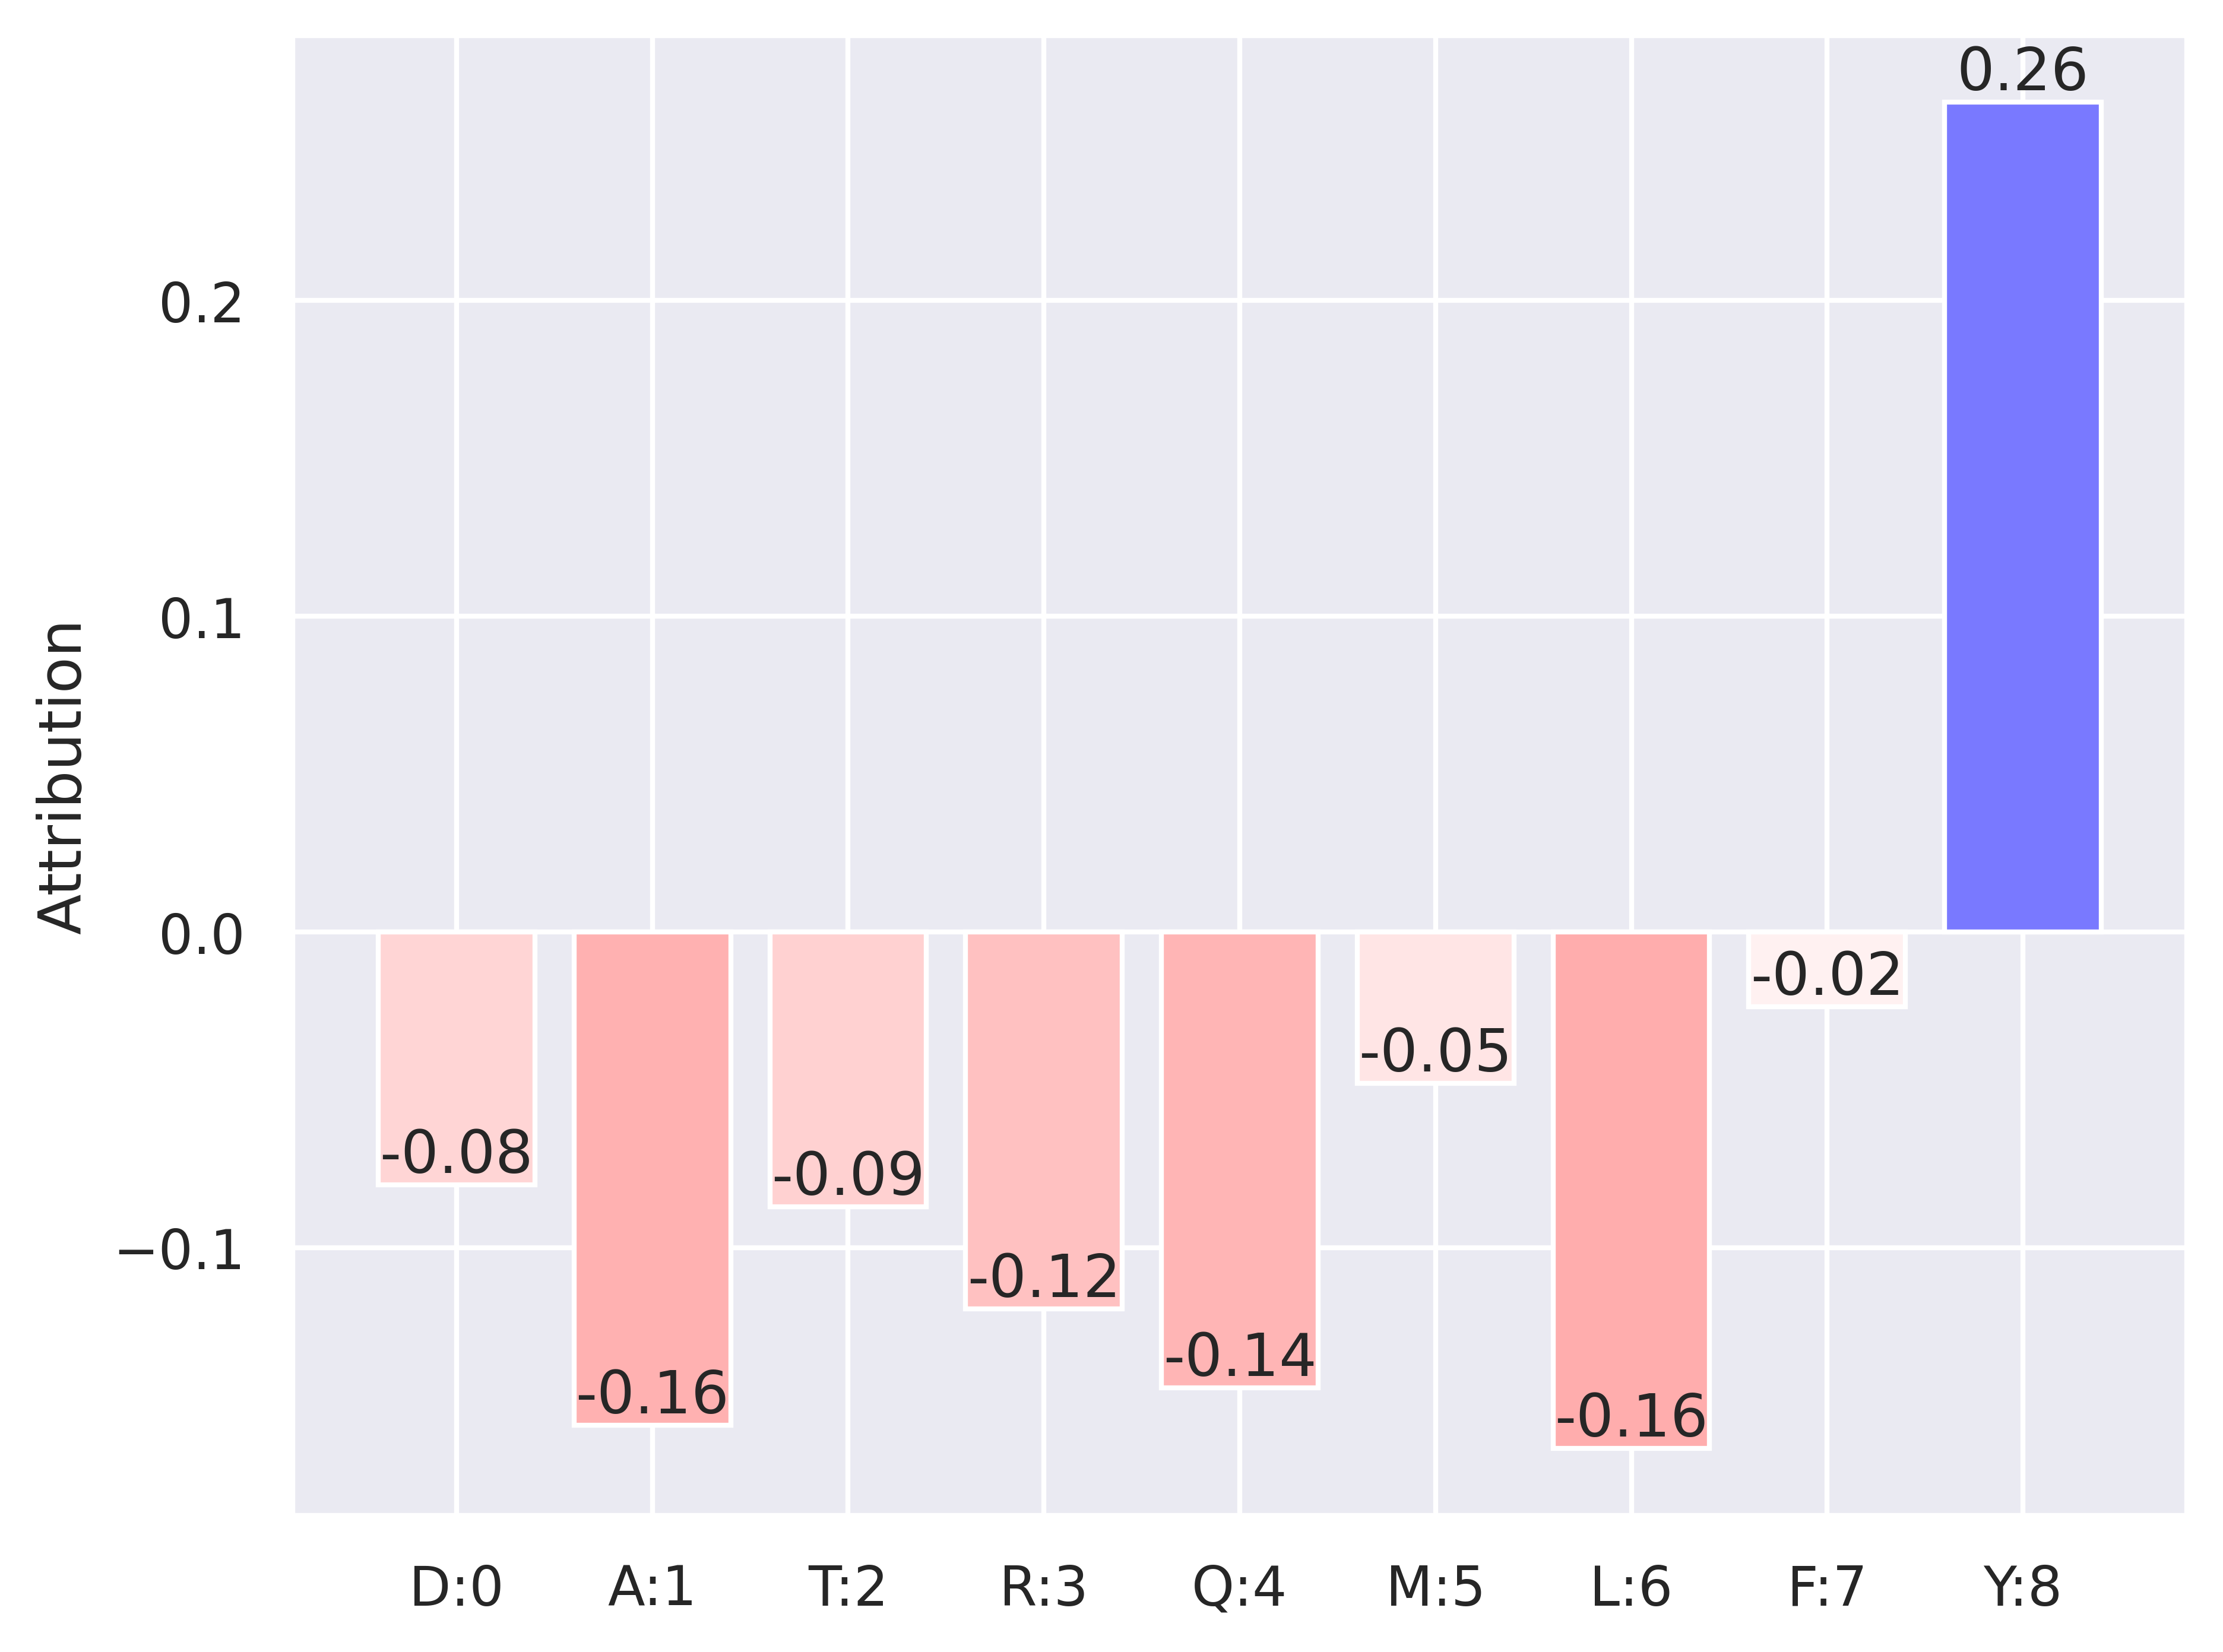

/root/mambaforge/envs/pepexplainer/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Attribution:  [ 0.05766721  0.0146749  -0.00644092  0.00989228  0.01111811 -0.02003923
 -0.0159502  -0.00301682  0.03717262]
SVSRQMLFR
prediction: 0.9742428
prediction_std: 0.011552171
mask_prediction: [0.91651154 0.9595669  0.9806838  0.9643502  0.9631243  0.99428475
 0.9901943  0.97725964 0.937053  ]
mask_prediction_std: [0.06337304 0.02629592 0.01700751 0.03861396 0.0293943  0.00373237
 0.00817107 0.01682369 0.03746876]
label: None
********Atribution********


/tmp/ipykernel_6667/2807886084.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 10)
[11:18:34] The new font size 1 is below the current minimum (6).


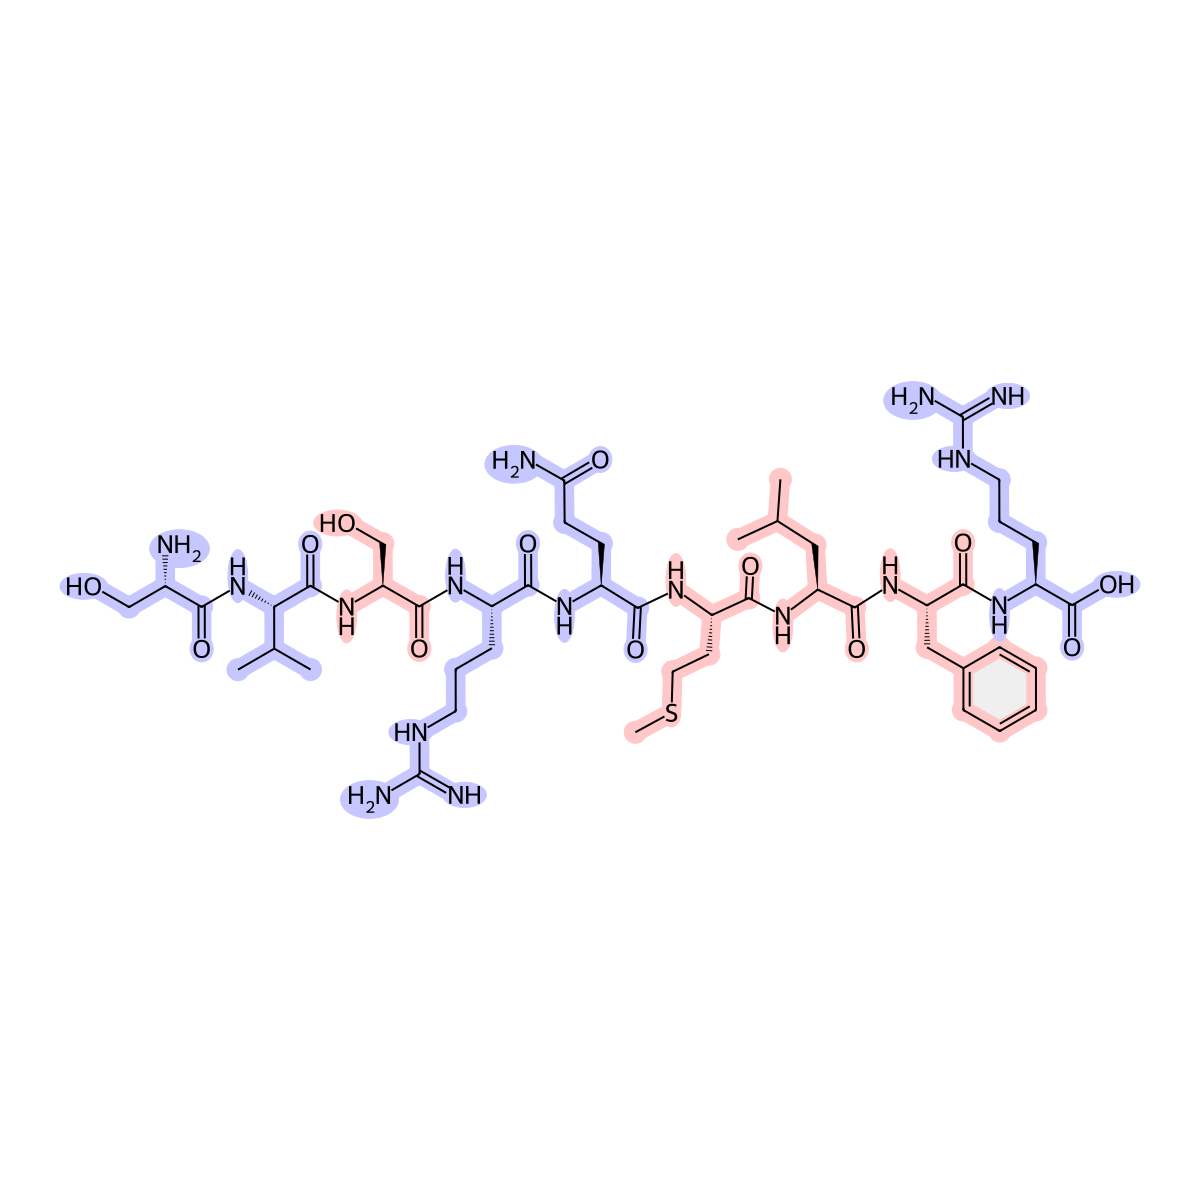

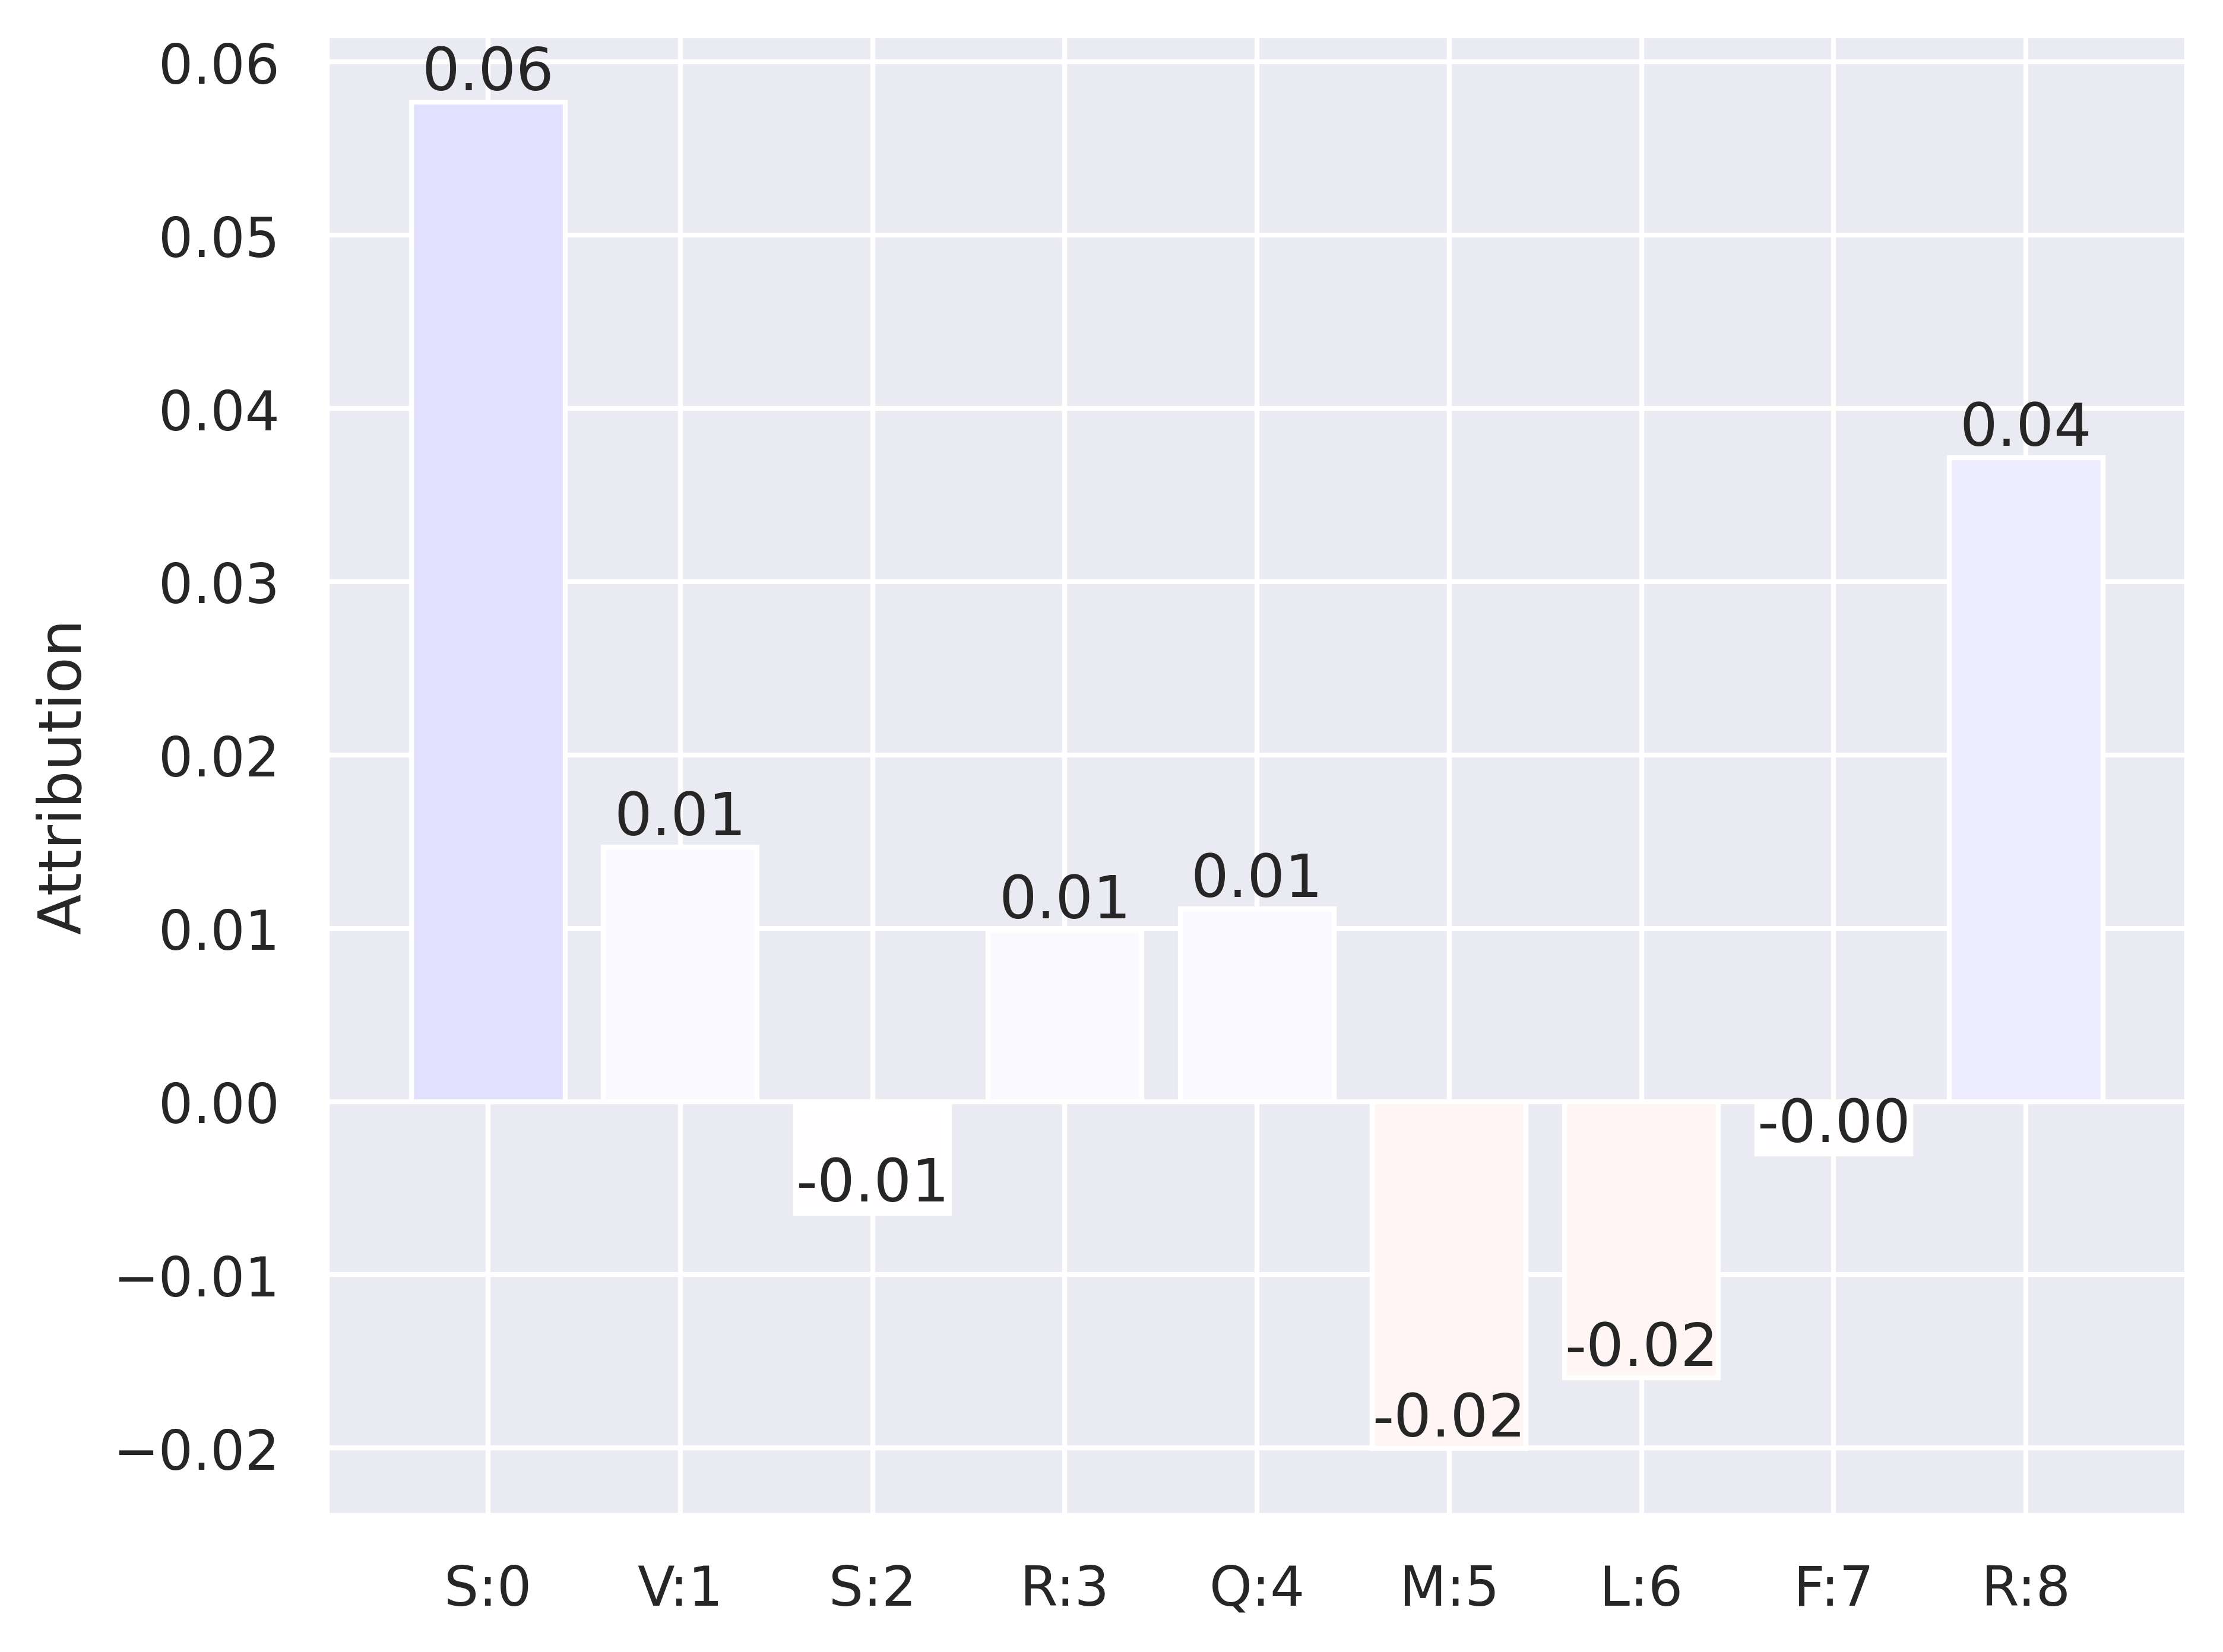

/root/mambaforge/envs/pepexplainer/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Attribution:  [ 0.05047932 -0.00113025 -0.00353605  0.01447115  0.00698436 -0.00887979
 -0.00425508  0.00670254  0.02533996]
ETIRQMLFR
prediction: 0.98941153
prediction_std: 0.0040131724
mask_prediction: [0.9388893  0.9905418  0.9929476  0.97493935 0.982427   0.9982915
 0.99366665 0.98270893 0.9640662 ]
mask_prediction_std: [0.05938669 0.00692961 0.0072907  0.02889524 0.01625518 0.00097195
 0.00775751 0.0173129  0.02085062]
label: None
********Atribution********


/tmp/ipykernel_6667/2807886084.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, 10)
[11:18:36] The new font size 1 is below the current minimum (6).


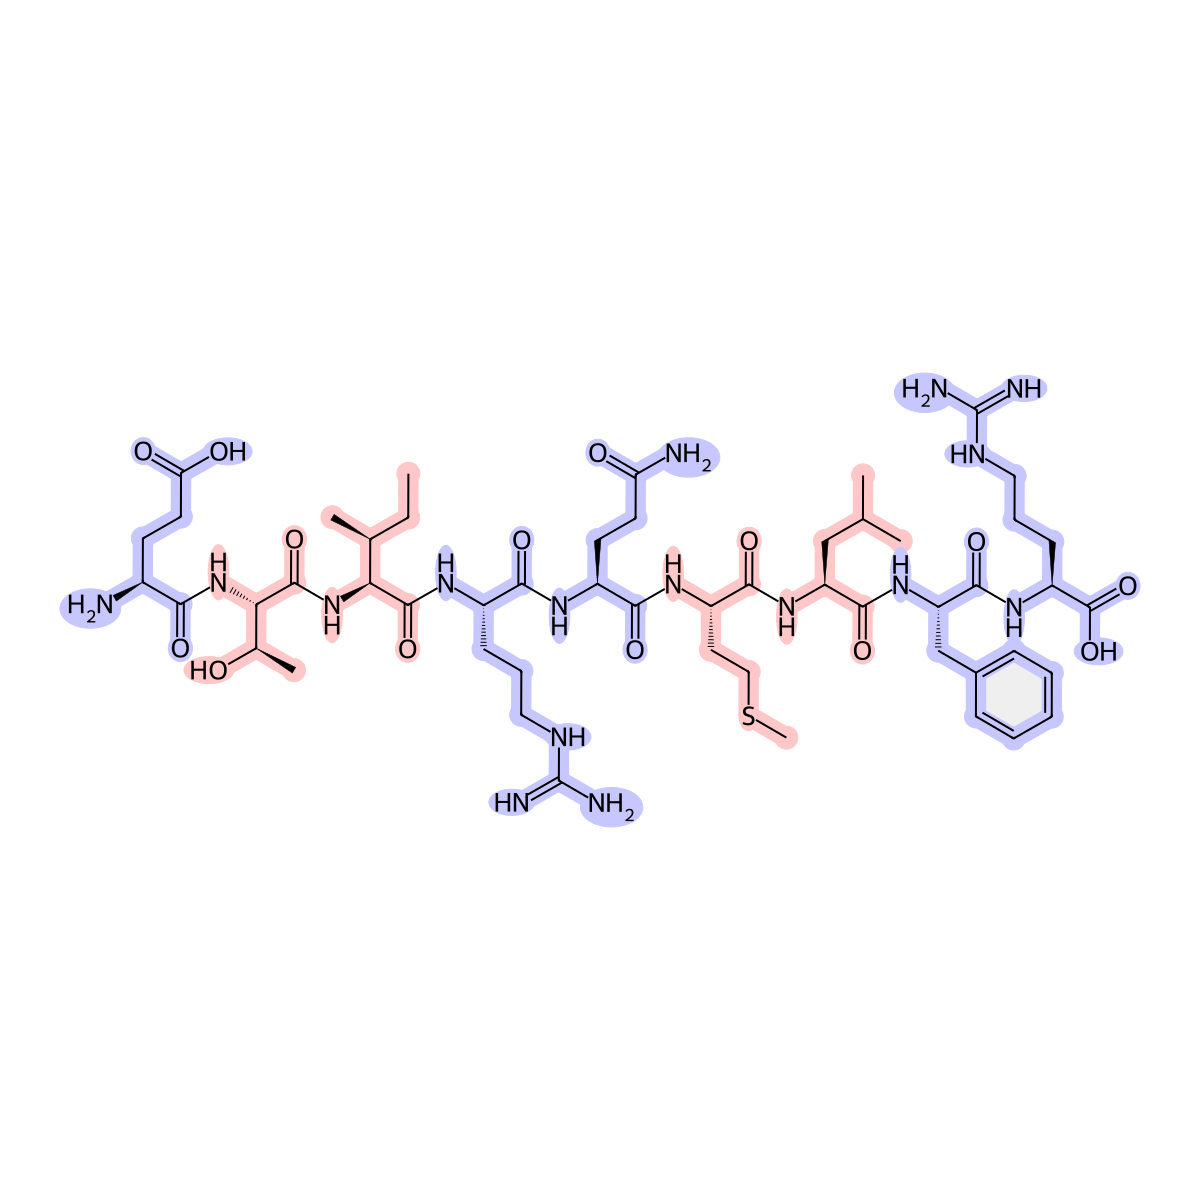

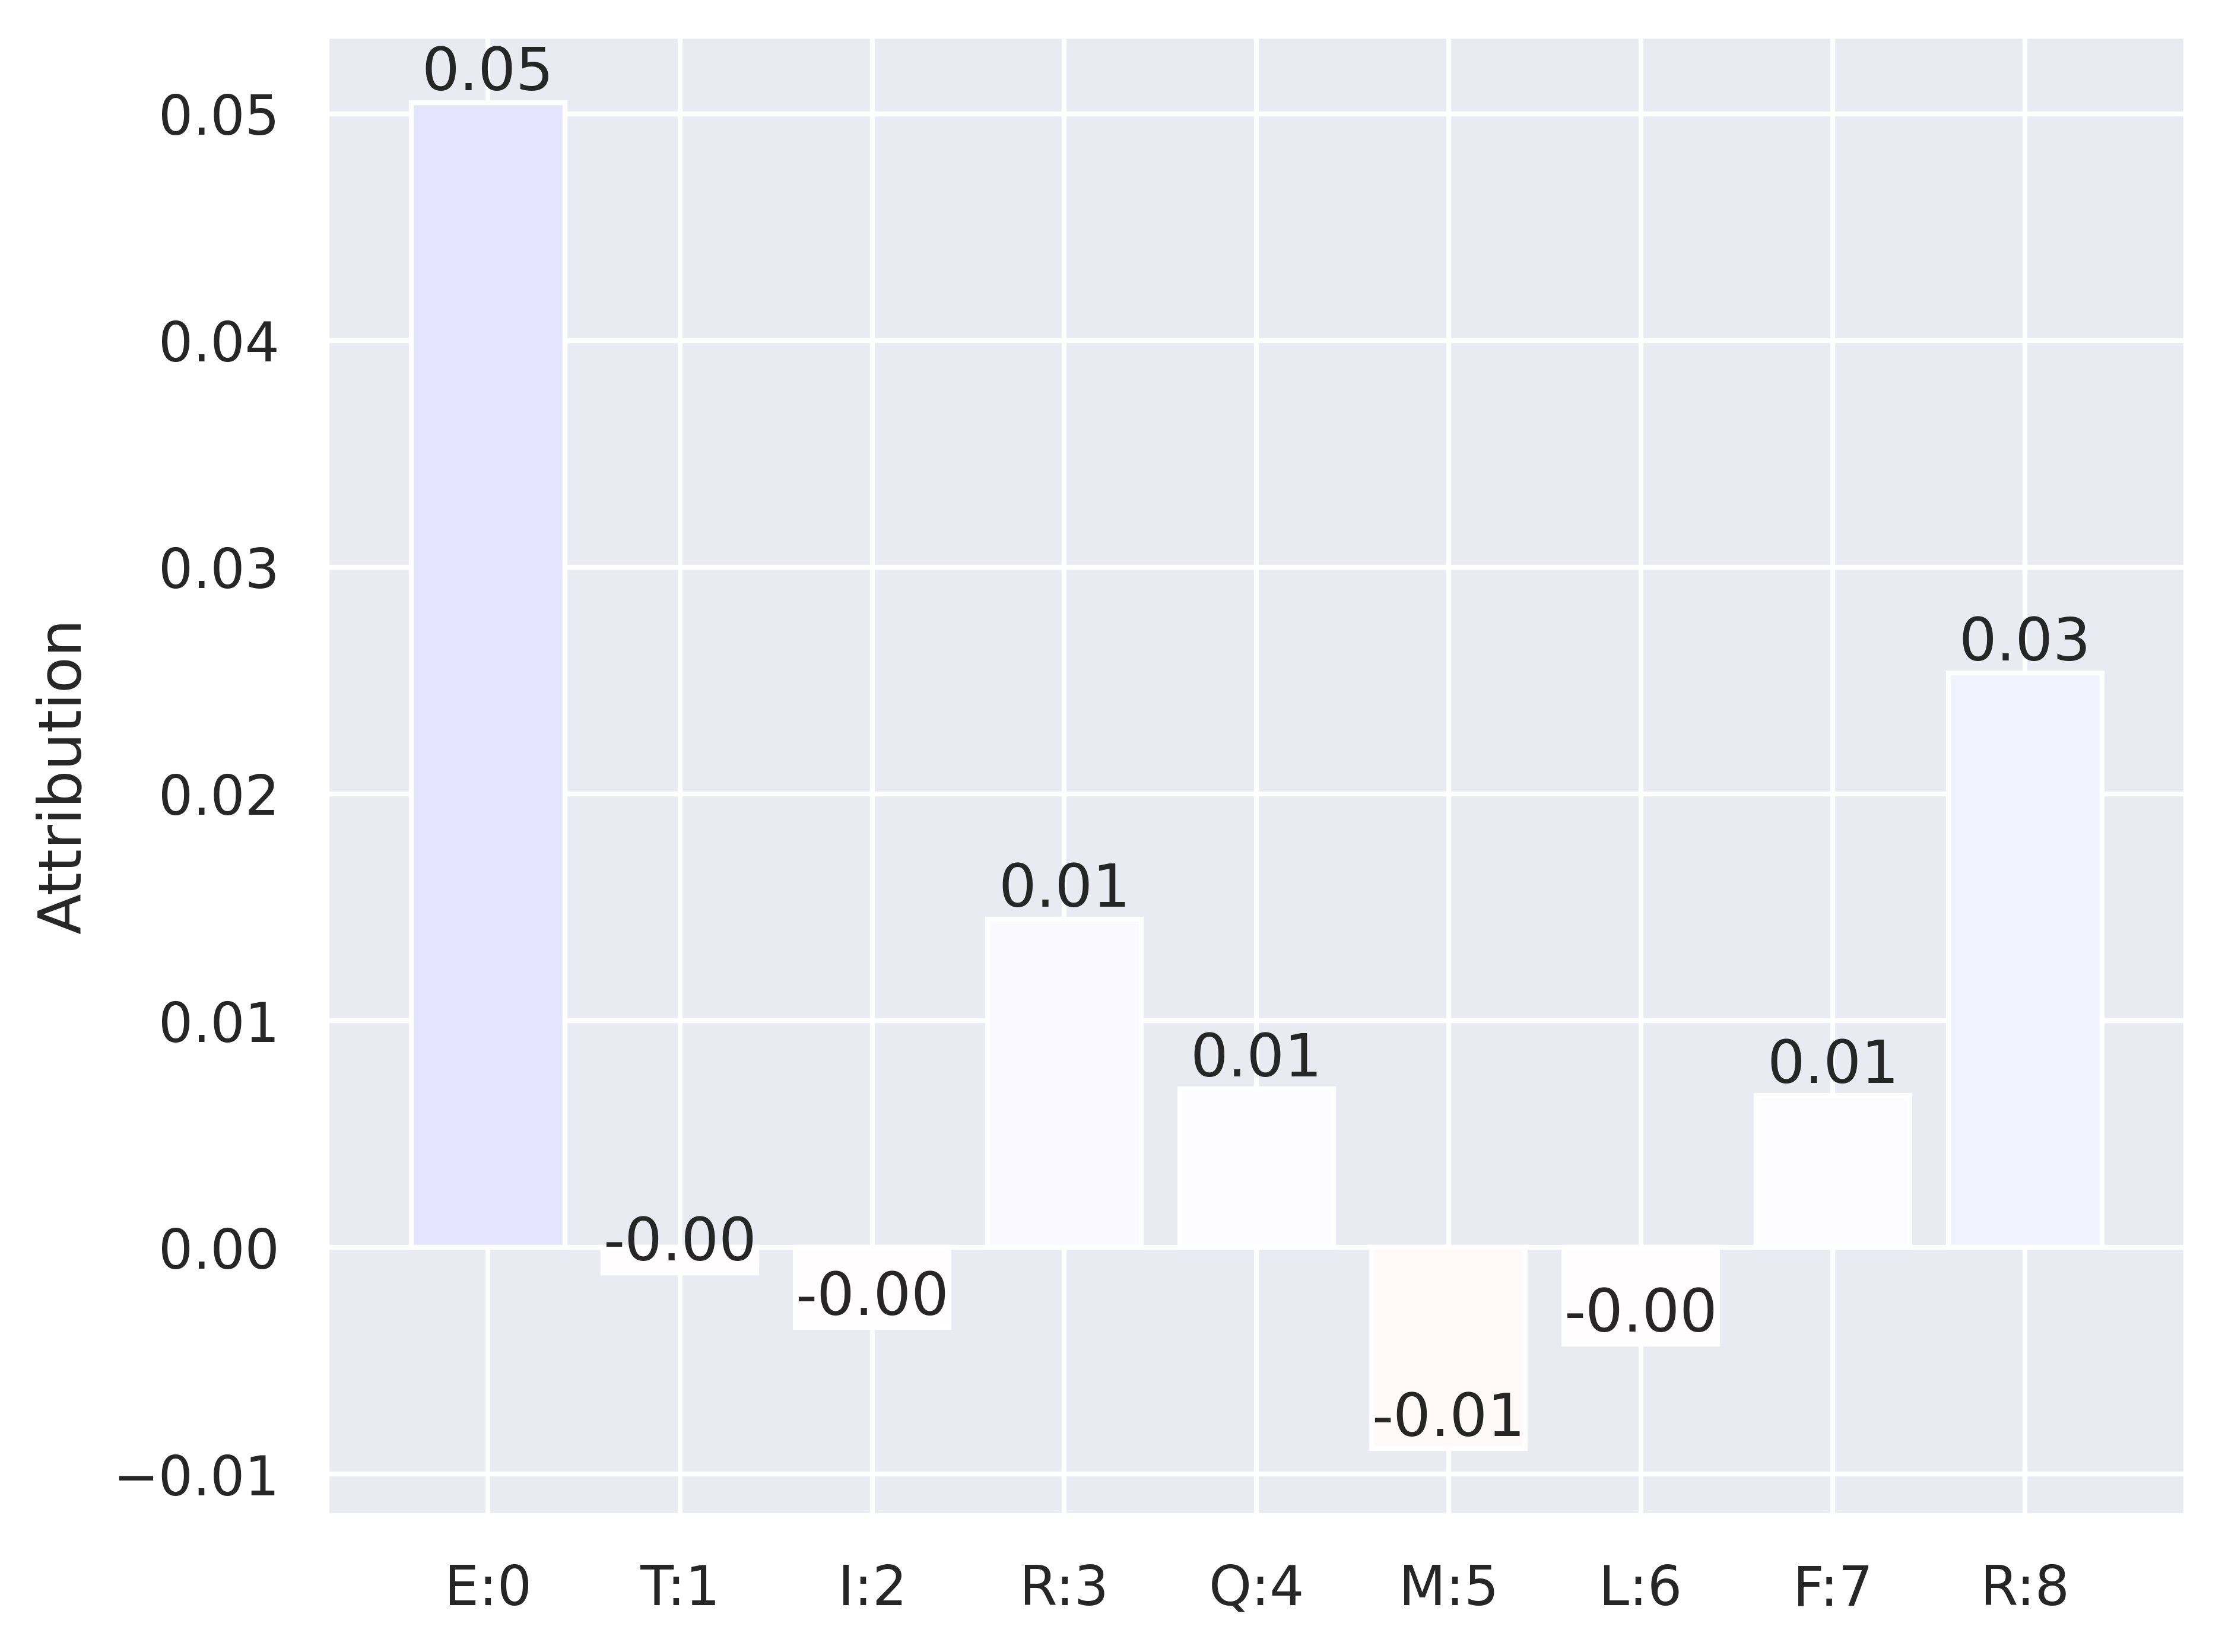

In [14]:
peptide_list = ["SATRQMLFY", "DATRQMLFY", "SVSRQMLFR", "ETIRQMLFR"]

for pep in peptide_list:
    visualize_peptide(Peptide(pep, "linear"))